### Import Library

In [1]:
# Base Library
import pandas as pd
import numpy as np

# Helper file
from src.utils.helpers import DataPreprocessor, Visualizer, DataAnalyzer, ModelEvaluator

# Data Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt

# Data Pre-processing Library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ML Algorithm Library
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Export model for deployment
import pickle

### Business Understanding
---

1. How can the most appropriate machine learning algorithm be selected for predicting house prices in Kabupaten Tangerang?
2. How can a house price prediction model for Kabupaten Tangerang be implemented as a web application using Streamlit?
3. How can the accuracy of the house price prediction model for Kabupaten Tangerang be measured?

### Data Understanding

In [2]:
# Read the data
df = pd.read_csv("./data/processed/hasil_scraping_rumah123.csv", engine='pyarrow', sep=';')
df = df.drop(columns=['URL', 'IMB', 'Lainnya', 'Garasi'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 4991 non-null   object
 1   Lokasi                4991 non-null   object
 2   Kamar Tidur           4991 non-null   int64 
 3   Kamar Mandi           4991 non-null   int64 
 4   Luas Tanah            4991 non-null   object
 5   Luas Bangunan         4991 non-null   object
 6   Sertifikat            4991 non-null   object
 7   Daya Listrik          4991 non-null   object
 8   Jumlah Lantai         4991 non-null   int64 
 9   Kondisi Properti      4991 non-null   object
 10  Carport               4991 non-null   int64 
 11  Kamar Tidur Pembantu  4991 non-null   int64 
 12  Kamar Mandi Pembantu  4991 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 507.0+ KB


In [3]:
# Take a peek of the first 5 data
df.head()

,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,Rp 1 Miliar,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,Rp 1 Miliar,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,Rp 1 Miliar,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


#### Exploratory Data Analysis

In [4]:
# Take a look of the brief statistics of the dataset
df.describe()

,Kamar Tidur,Kamar Mandi,Jumlah Lantai,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
count,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000
mean,3.407734,2.783811,1.902424,1.393308,0.598077,0.520537
std,1.400634,1.501217,0.565806,0.702549,0.620579,0.576362
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000
50%,3.000000,3.000000,2.000000,1.000000,1.000000,0.000000
75%,4.000000,3.000000,2.000000,2.000000,1.000000,1.000000
max,34.000000,34.000000,4.000000,10.000000,5.000000,15.000000


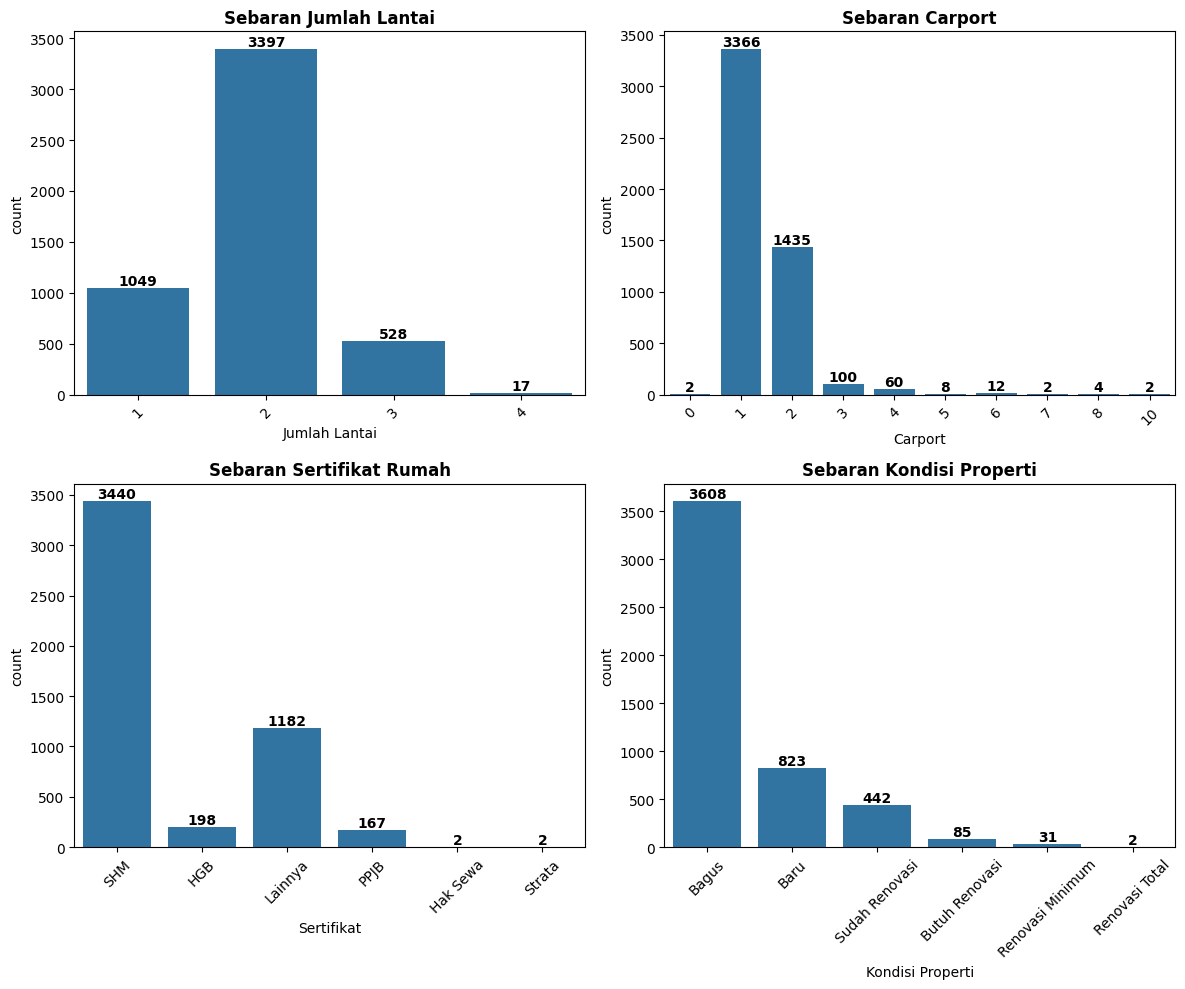

In [5]:
# Visualize some columns
# Creating a figure with 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of rows and columns
columns = ['Jumlah Lantai', 'Carport', 'Sertifikat', 'Kondisi Properti']
titles = ['Sebaran Jumlah Lantai', 'Sebaran Carport', 'Sebaran Sertifikat Rumah', 'Sebaran Kondisi Properti']

# Loop to create countplot and add the data label
for i, ax in enumerate(axes.flat):
    sns.countplot(x=df[columns[i]], ax=ax)
    ax.set_title(titles[i], weight='bold')

    # Add data label above the data bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        
    # Rotate x label for 45 degree
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjusting the layouts
plt.tight_layout()
plt.show()

### Data Preparation

Before creating the ML model, here I will do the following process of Data Pre-processing:
1. Convert Data Types: <br>Cleaned and converted object/string columns into numeric types to make them suitable for mathematical operations.
2. Feature Extraction: <br>Extracted the district (Kecamatan) from the full Lokasi string to create a more structured and impactful categorical feature.
3. Filtering Data: <br>Filtered the dataset to eliminate anomaly.
4. Outliers Handling: <br>Capped extreme values in key numeric columns using the IQR method to prevent them from skewing the model's training process.
5. Encoding: <br>Transformed categorical features into a numerical format using One-Hot Encoding, allowing the machine learning models to process them.
6. Feature Selection: <br>Separated the data into predictor variables (X) and the target variable (y, Harga) in preparation for model training.
7. Data Splitting: <br>Divided the dataset into training (80%) and testing (20%) sets to ensure the model is evaluated on unseen data for an unbiased performance assessment.


#### Import helpers.py file

In [6]:
# Initialize classes
preprocessor = DataPreprocessor()
visualizer = Visualizer()
analyzer = DataAnalyzer()

#### Convert Data Types

In [7]:
# Clean 'Harga' column and convert data types into proper format
df['Harga'] = df['Harga'].apply(preprocessor.convert_price)
df = preprocessor.clean_numeric_columns(df)
df = preprocessor.clean_condition_column(df)

# Check the result on the top 5 rows of the dataset
df.head()

,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,1000000000,"BSD, Tangerang",4,2,114,147,SHM,1300,2,Bagus,1,0,0
1,1000000000,"Tangerang, Tangerang",2,1,126,60,SHM,2200,1,Bagus,1,0,0
2,1000000000,"BSD City, Tangerang",3,2,84,81,HGB,1300,2,Bagus,1,0,0
3,1000000000,"BSD, Tangerang",3,2,103,66,SHM,1300,1,Bagus,1,0,0
4,1000000000,"BSD, Tangerang",3,2,103,66,SHM,1300,1,Bagus,1,0,0


In [8]:
# Check the data type is converted correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 4991 non-null   int64 
 1   Lokasi                4991 non-null   object
 2   Kamar Tidur           4991 non-null   Int64 
 3   Kamar Mandi           4991 non-null   Int64 
 4   Luas Tanah            4991 non-null   Int64 
 5   Luas Bangunan         4991 non-null   Int64 
 6   Sertifikat            4991 non-null   object
 7   Daya Listrik          4991 non-null   Int64 
 8   Jumlah Lantai         4991 non-null   Int64 
 9   Kondisi Properti      4991 non-null   object
 10  Carport               4991 non-null   Int64 
 11  Kamar Tidur Pembantu  4991 non-null   Int64 
 12  Kamar Mandi Pembantu  4991 non-null   Int64 
dtypes: Int64(9), int64(1), object(3)
memory usage: 550.9+ KB


In [9]:
# # Location check
# # Check if 'Lokasi' column is in the dataset
# if "Lokasi" in df.columns:
#     # Count the values of each location
#     lokasi_counts = df["Lokasi"].value_counts()
    
#     # Save the file in .txt format
#     file_path = "./data/processed/lokasi_counts.txt"
#     lokasi_counts.to_csv(file_path, sep="\t", header=True)

#     print(f"Results saved on: {file_path}")
# else:
#     print("'Lokasi' column can't be found on the dataset.")

#### Feature Extraction

In [10]:
# Extract subdistrict name from 'Lokasi' column
df['Kecamatan'] = df['Lokasi'].apply(preprocessor.extract_kecamatan)

# Exclude houses data that are not located in Tangerang Regency
df_kabupaten = preprocessor.filter_tangerang_regency(df)

# Check the top 5 rows of the dataset after subdistrict name extraction
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu,Kecamatan
6,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
8,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
14,1000000000,3,2,644,135,SHM,1300,1,Bagus,1,0,0,Balaraja
15,1000000000,3,2,66,79,SHM,3500,2,Bagus,1,0,0,Pasar Kemis
21,1000000000,3,3,120,166,SHM,1300,2,Baru,2,1,0,Cikupa


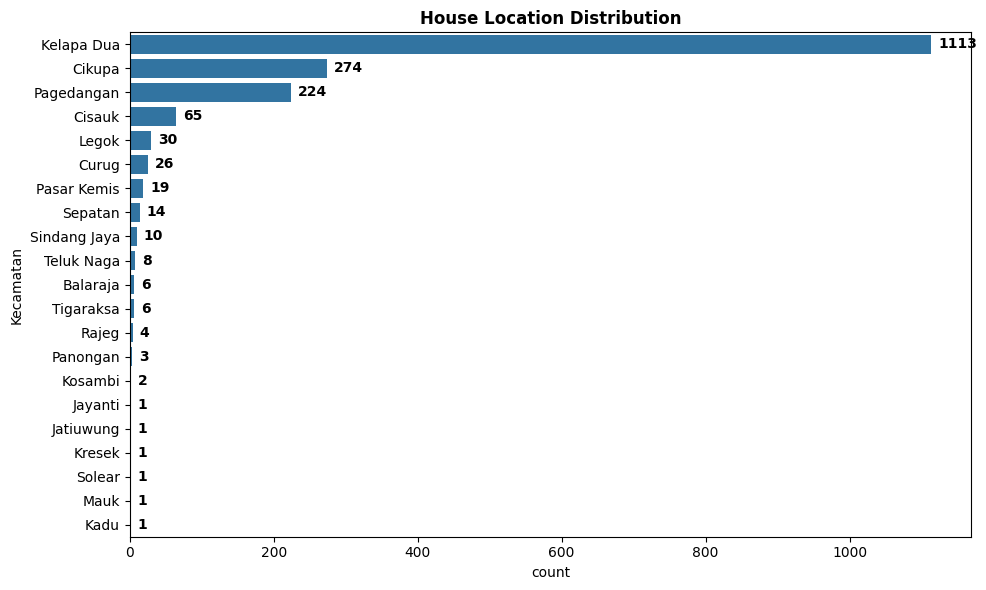

In [11]:
# View subdistrict distribution
visualizer.plot_location_distribution(df_kabupaten)

#### Filtering Data

In [12]:
# Filter the data to remove anomaly exists on the dataset.
df_kabupaten = preprocessor.apply_filters(df_kabupaten)

# Check the filter result
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1798 entries, 6 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 1798 non-null   int64 
 1   Kamar Tidur           1798 non-null   Int64 
 2   Kamar Mandi           1798 non-null   Int64 
 3   Luas Tanah            1798 non-null   Int64 
 4   Luas Bangunan         1798 non-null   Int64 
 5   Sertifikat            1798 non-null   object
 6   Daya Listrik          1798 non-null   Int64 
 7   Jumlah Lantai         1798 non-null   Int64 
 8   Kondisi Properti      1798 non-null   object
 9   Carport               1798 non-null   Int64 
 10  Kamar Tidur Pembantu  1798 non-null   Int64 
 11  Kamar Mandi Pembantu  1798 non-null   Int64 
 12  Kecamatan             1798 non-null   object
dtypes: Int64(9), int64(1), object(3)
memory usage: 212.5+ KB


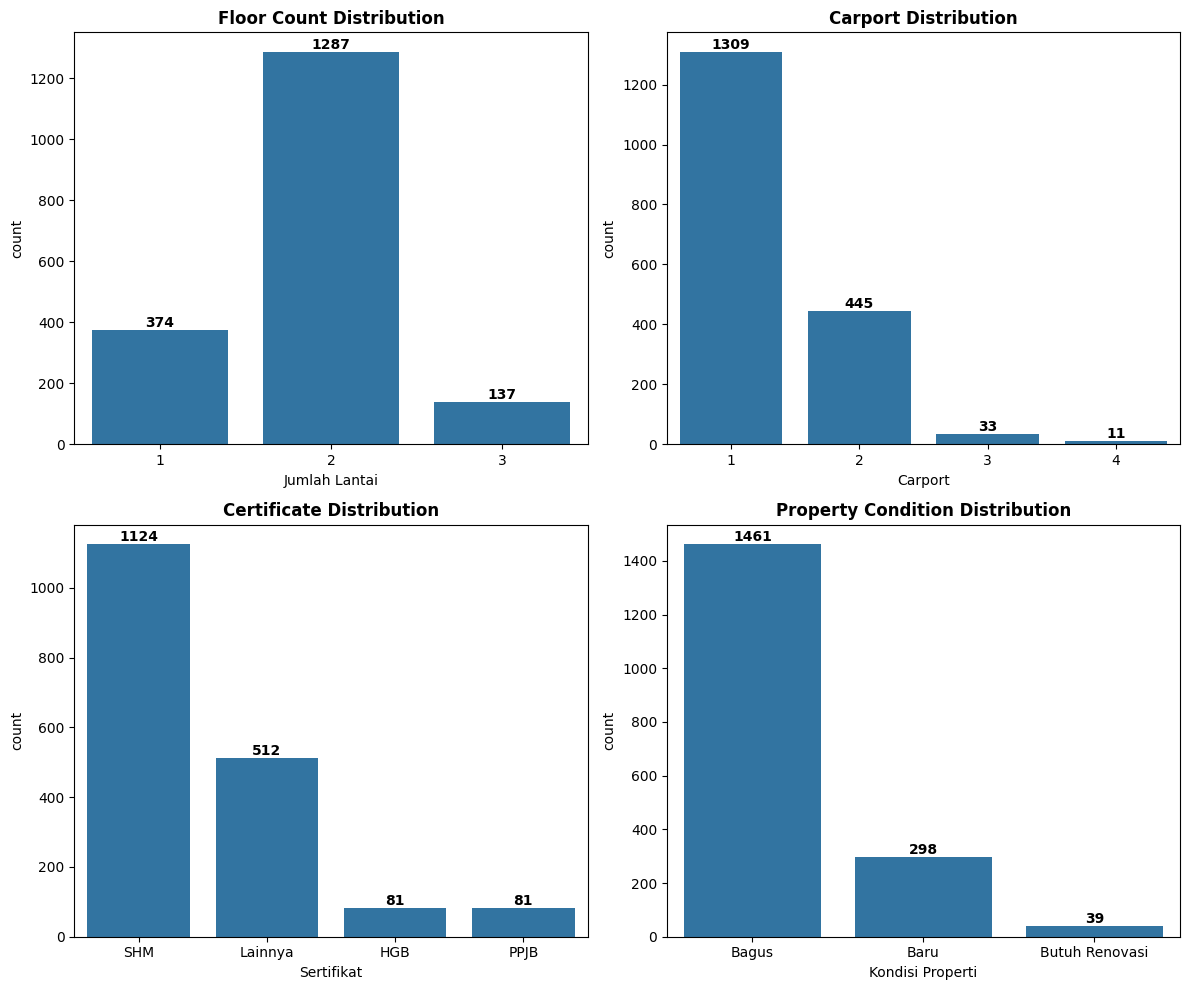

In [13]:
# Visualization of floor count distribution, carport distribution, certificate distribution, property condition distribution
visualizer.plot_categorical_distributions(df_kabupaten)

In [14]:
# Export Dataset for filter
# df_kabupaten.info()
# df_kabupaten.to_csv("../Dataset/Data Harga Rumah Kabupaten Tangerang.csv", index=False)

#### Encoding

In [15]:
# Encoding for categorical values.
df_encoded, daya_listrik_encoder = preprocessor.encode_categorical_features(df_kabupaten)

# Check the encoded dataset
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1798 entries, 6 to 4990
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Harga                 1798 non-null   int64  
 1   Kamar Tidur           1798 non-null   Int64  
 2   Kamar Mandi           1798 non-null   Int64  
 3   Luas Tanah            1798 non-null   Int64  
 4   Luas Bangunan         1798 non-null   Int64  
 5   Sertifikat            1798 non-null   float64
 6   Daya Listrik          1798 non-null   float64
 7   Jumlah Lantai         1798 non-null   Int64  
 8   Kondisi Properti      1798 non-null   float64
 9   Carport               1798 non-null   Int64  
 10  Kamar Tidur Pembantu  1798 non-null   Int64  
 11  Kamar Mandi Pembantu  1798 non-null   Int64  
 12  kec_Balaraja          1798 non-null   bool   
 13  kec_Cikupa            1798 non-null   bool   
 14  kec_Cisauk            1798 non-null   bool   
 15  kec_Curug             1798

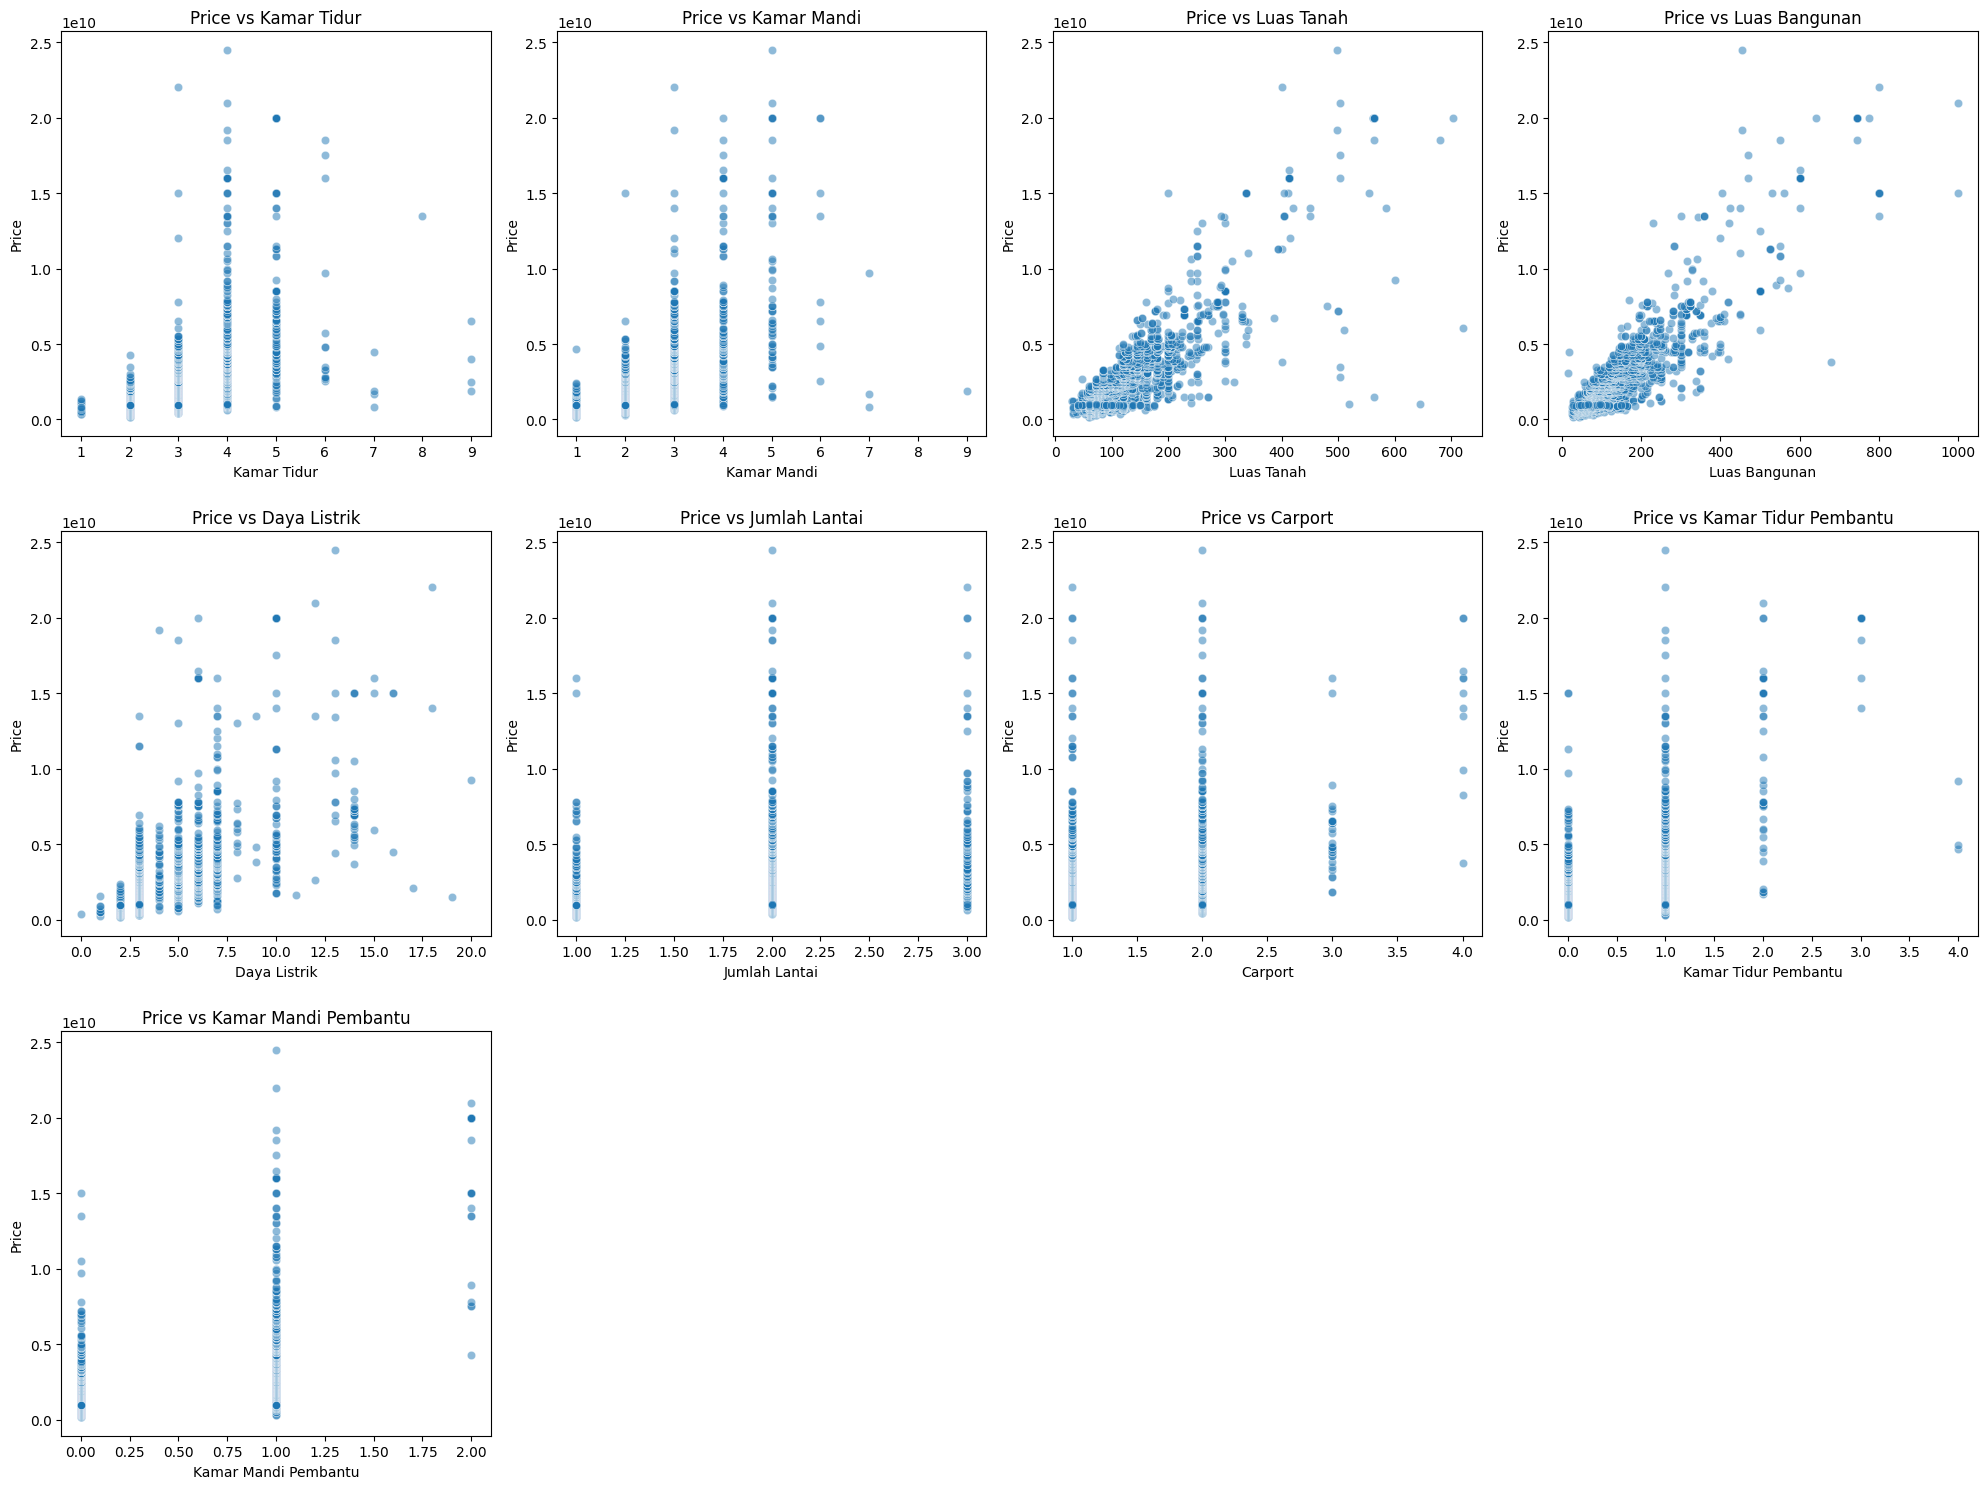

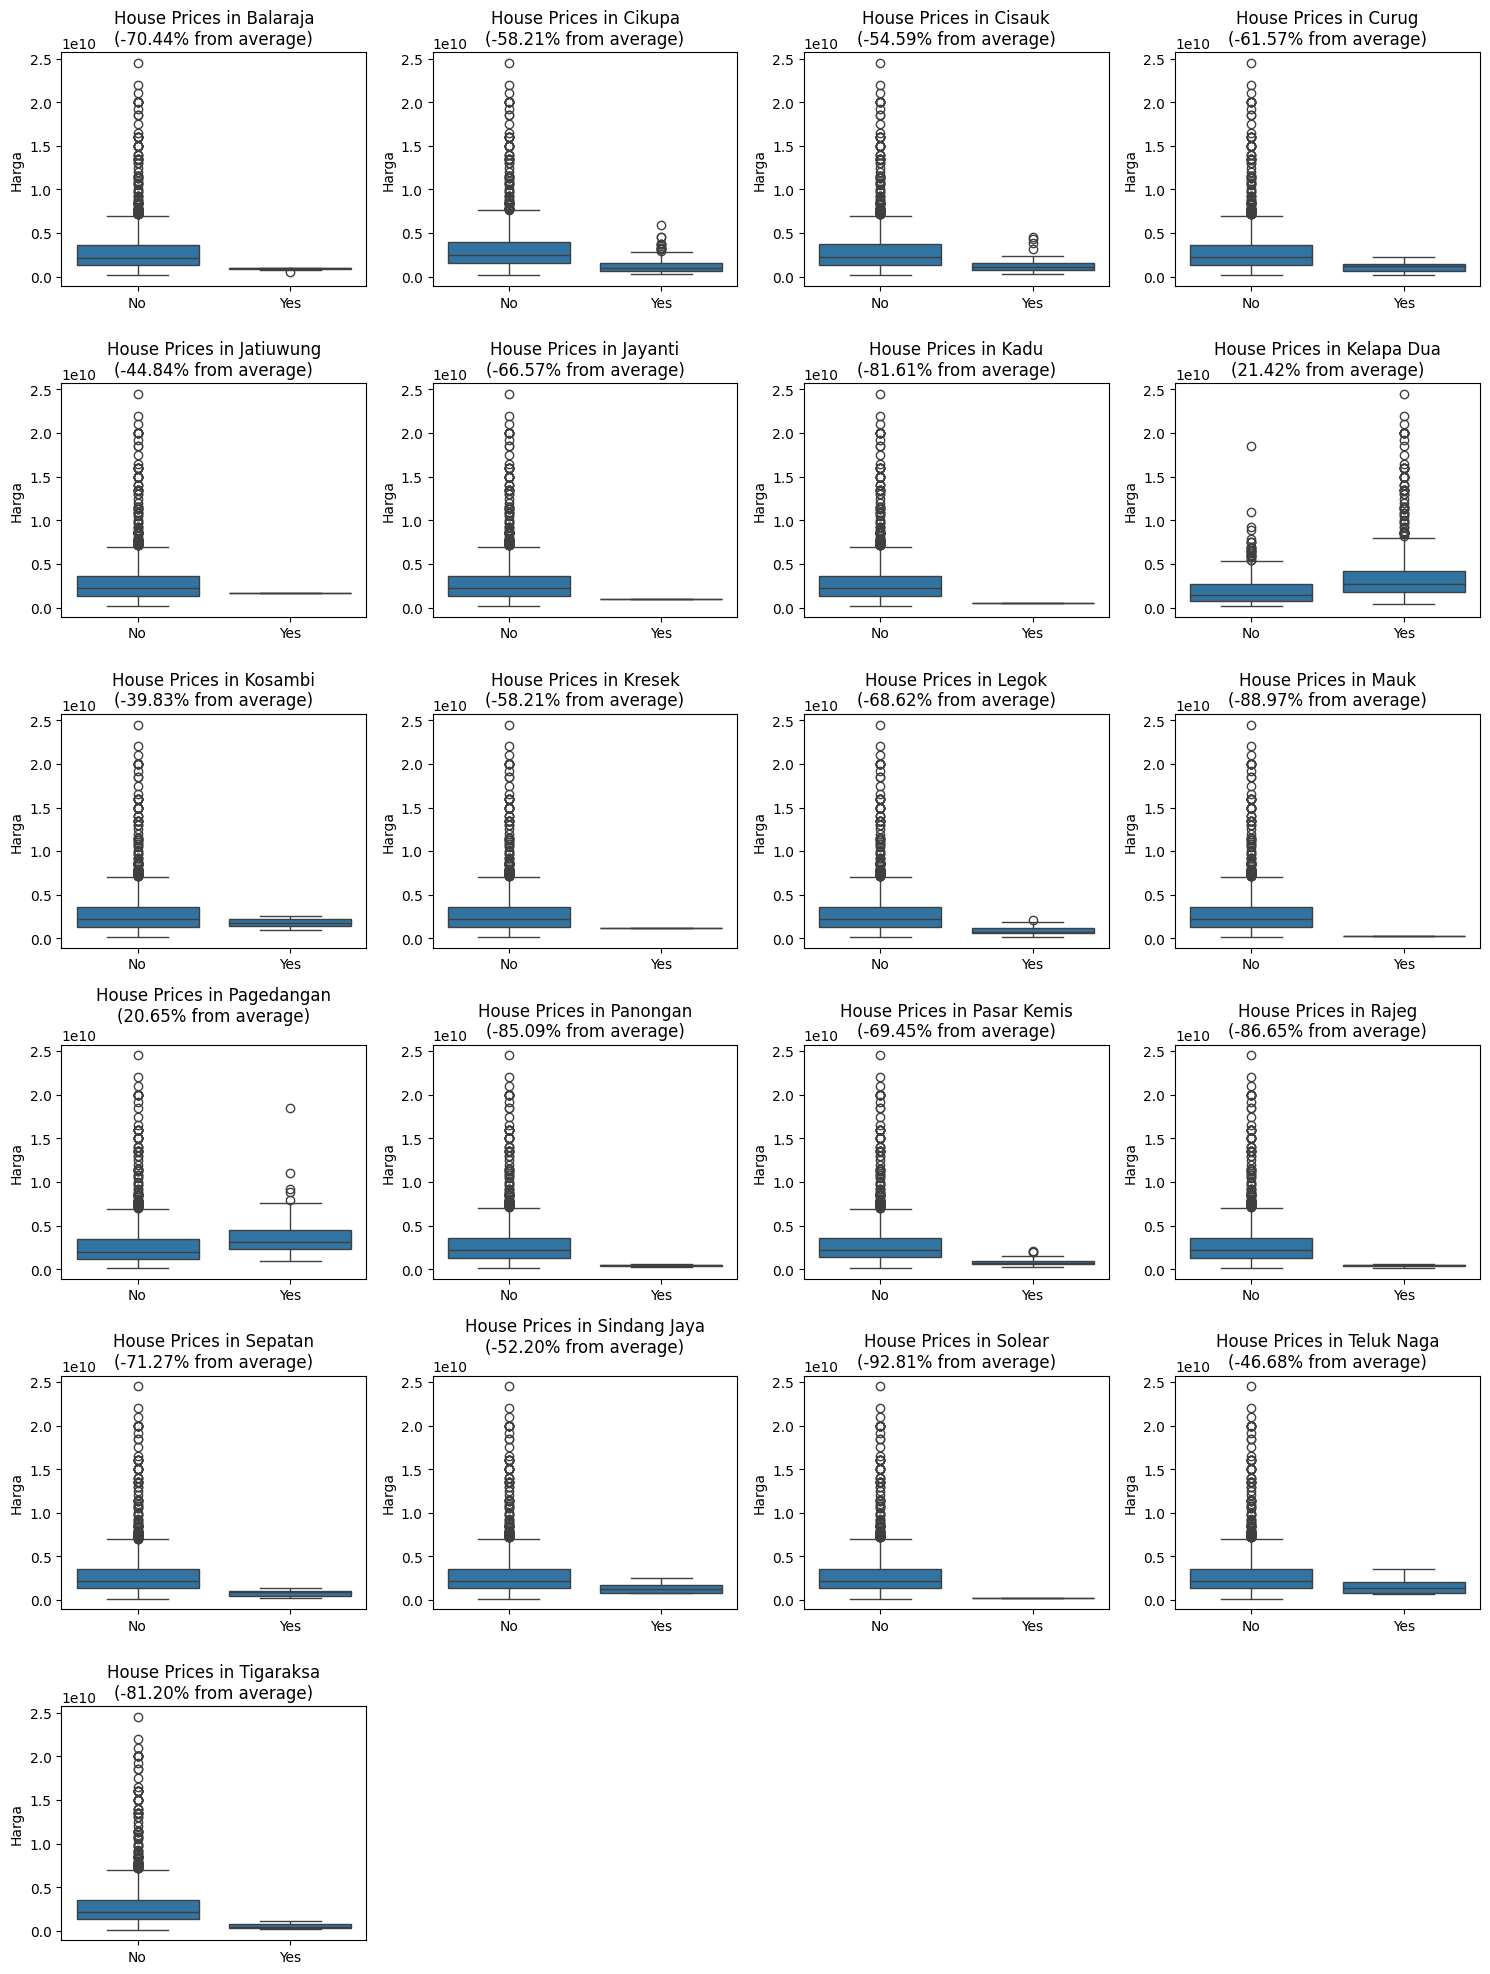

Overall average price: 2,991,479,421.57


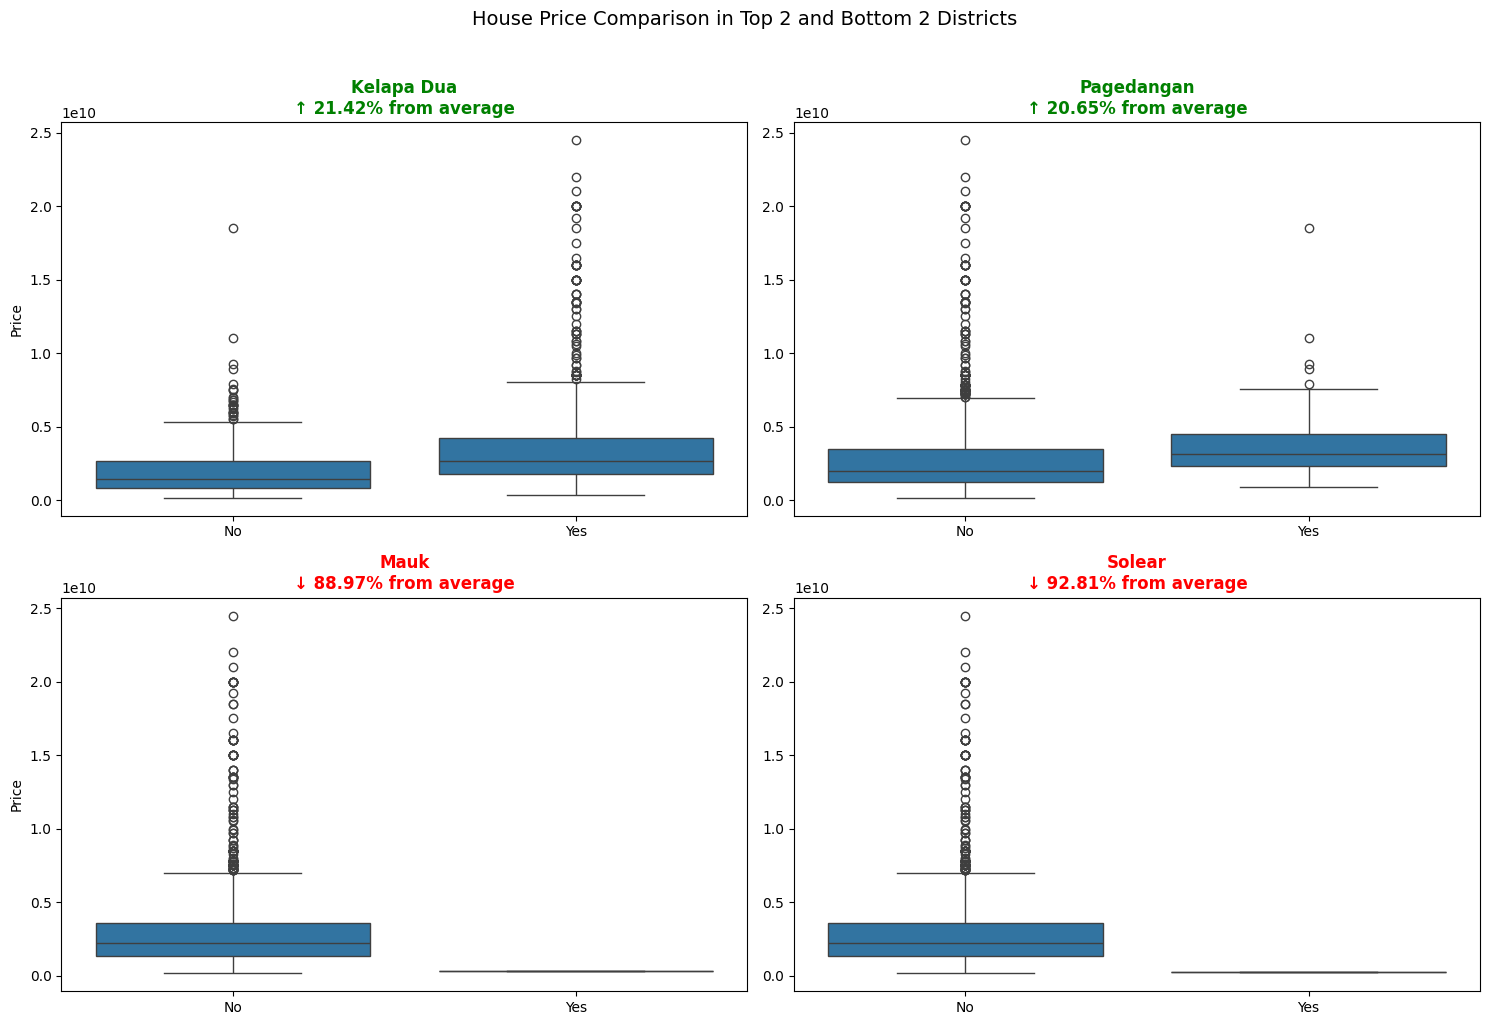

,kecamatan,avg_price,pct_diff
18,Solear,"Rp 215,000,000",-92.81%
11,Mauk,"Rp 330,000,000",-88.97%
7,Kelapa Dua,"Rp 3,632,154,125",+21.42%
12,Pagedangan,"Rp 3,609,285,714",+20.65%


In [16]:
# Price vs Numerical vars scatter plot
excluded_columns = ['Harga']
numerical_vars = [col for col in df_kabupaten.select_dtypes(include=['int64', 'float64']).columns if col not in excluded_columns]
visualizer.plot_numeric_vs_price(df_encoded, numerical_vars)

# Boxplot of house price in each subdistrict
visualizer.plot_all_kecamatan_boxplots(df_encoded)

# Comparison between the top and bottom subdistrict houses
visualizer.plot_kecamatan_price_comparison(df_encoded)

#### Outliers Handling

Outliers in the Harga column were capped using the IQR method to prevent extreme values from skewing the model's performance. This is preferred over removal to retain as much data as possible.

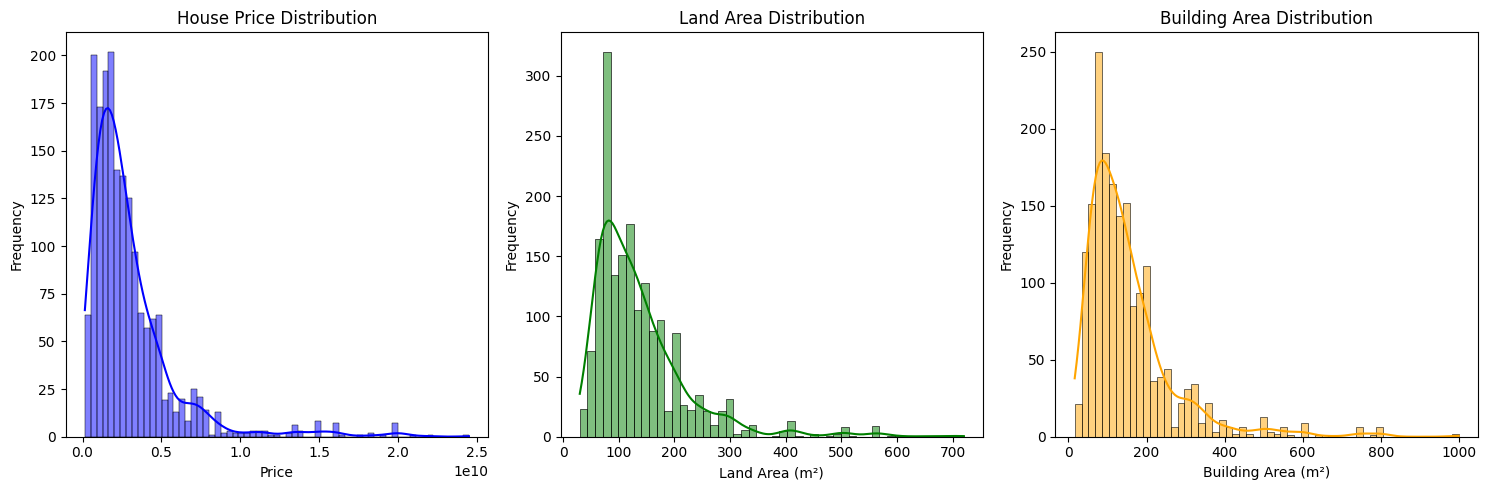

In [17]:
# Check the initial distribution of 'Harga', 'Luas Tanah', 'Luas Bangunan' columns
visualizer.plot_price_distributions(df_encoded)

In [18]:
# Check skewness of each column
analyzer.calculate_skewness(df_encoded)

Skewness of the 'Harga' column distribution:  3.08
Skewness of the 'Luas Tanah' column distribution:   2.4
Skewness of the 'Luas Bangunan' column distribution:  2.63


{'Harga': np.float64(3.08),
 'Luas Tanah': np.float64(2.4),
 'Luas Bangunan': np.float64(2.63)}

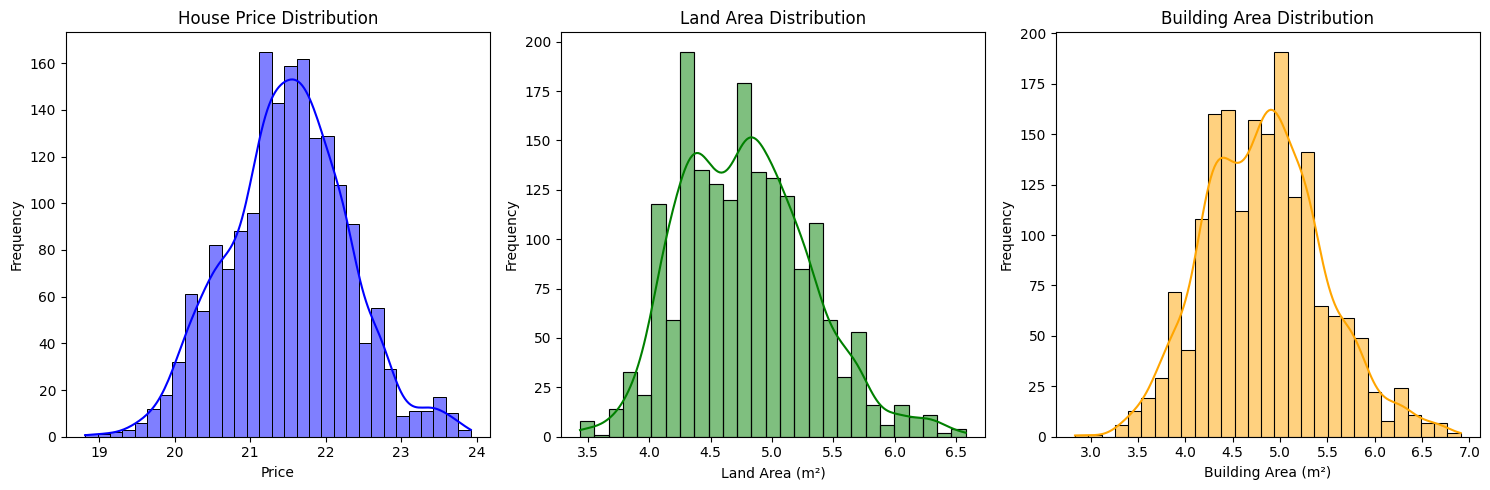

In [19]:
# Log transformation
df_final = preprocessor.apply_log_transformation(df_encoded)

# See the result of log transformation
visualizer.plot_price_distributions(df_final)

#### Feature Selection

Using pearson correlation.

In [20]:
# Pearson correlation analysis for feature selection
corr_analysis = analyzer.analyze_correlations(df_final)
print("Strong correlations:", corr_analysis['strong_correlation_vars'])

Strong correlations: ['Luas Bangunan', 'Luas Tanah', 'Kamar Mandi', 'Daya Listrik', 'Kamar Tidur', 'Kamar Mandi Pembantu', 'Kamar Tidur Pembantu', 'Jumlah Lantai', 'Carport']


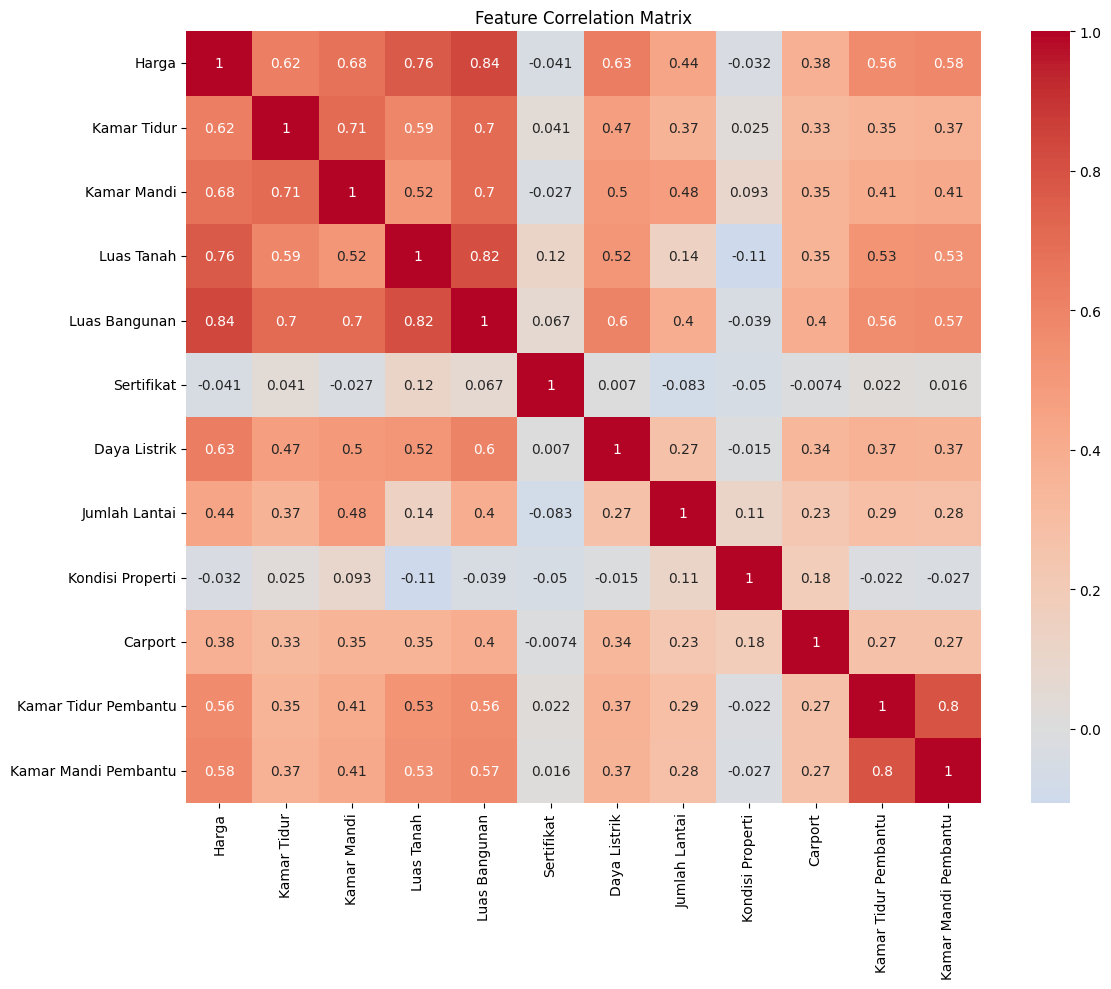

In [21]:
# Check the correlation heatmap
visualizer.plot_correlation_heatmap(df_final)

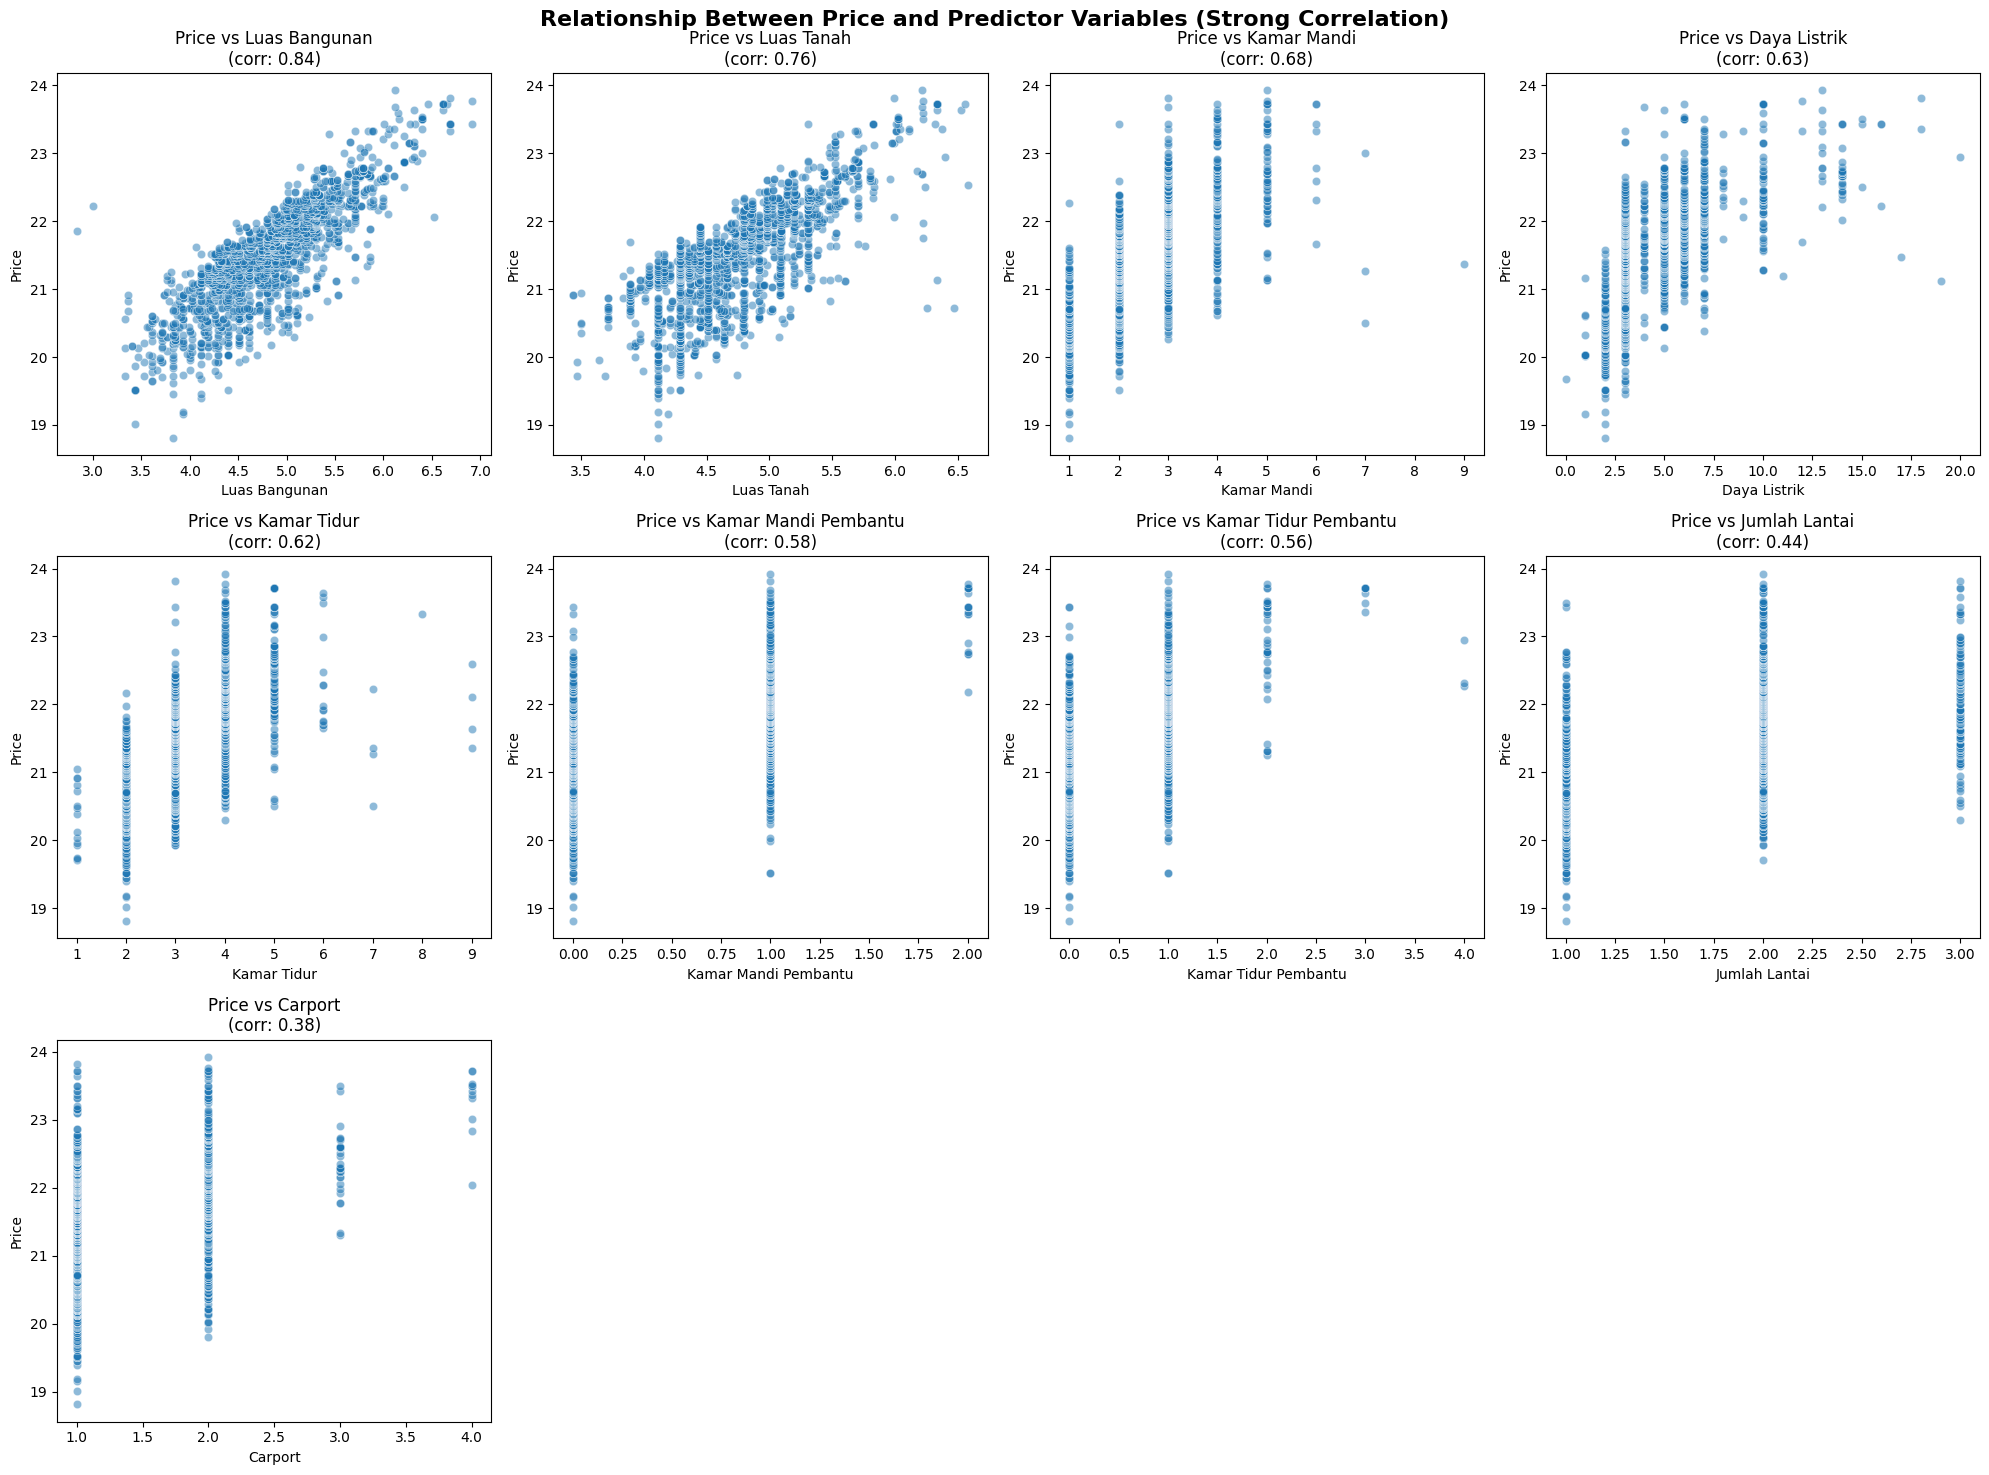

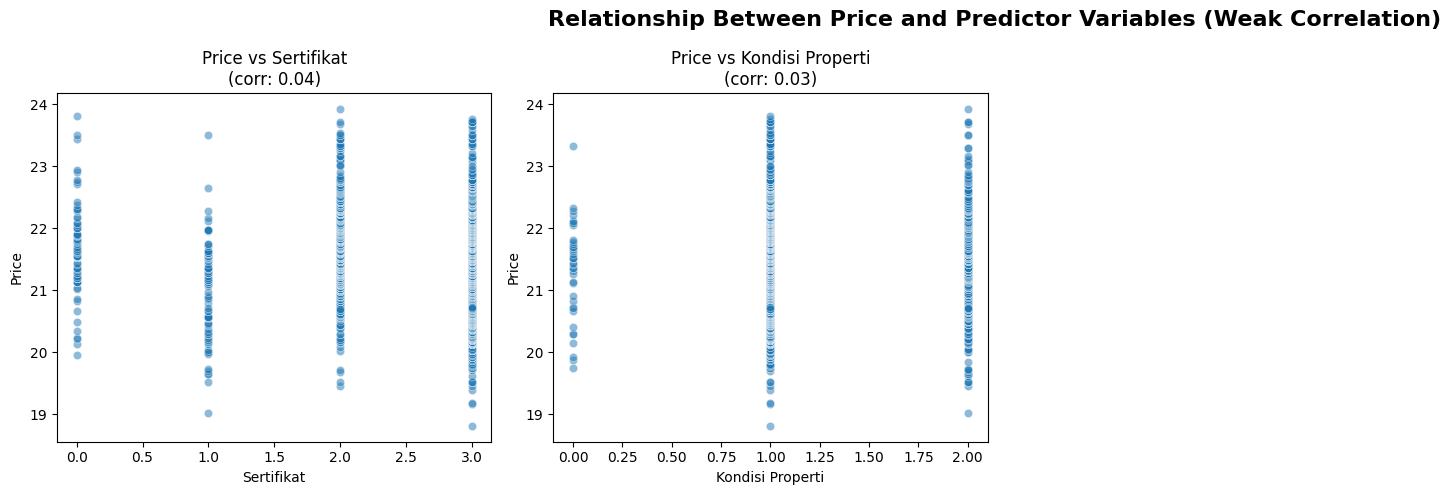

Strong correlation variables: ['Luas Bangunan', 'Luas Tanah', 'Kamar Mandi', 'Daya Listrik', 'Kamar Tidur', 'Kamar Mandi Pembantu', 'Kamar Tidur Pembantu', 'Jumlah Lantai', 'Carport']
Weak correlation variables: ['Sertifikat', 'Kondisi Properti']
All correlations: Luas Bangunan           0.838479
Luas Tanah              0.762454
Kamar Mandi             0.678993
Daya Listrik            0.631578
Kamar Tidur             0.623999
Kamar Mandi Pembantu    0.580251
Kamar Tidur Pembantu    0.564324
Jumlah Lantai           0.440478
Carport                 0.376543
Sertifikat              0.041082
Kondisi Properti        0.031863
dtype: float64


In [22]:
corr_results = visualizer.plot_correlation_scatter_grids(df_final)

# Access the results
print("Strong correlation variables:", corr_results['strong_correlation_vars'])
print("Weak correlation variables:", corr_results['weak_correlation_vars'])
print("All correlations:", corr_results['correlations'])

In [23]:
# Check the final dataset before continue to the next part
df_final.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,...,kec_Mauk,kec_Pagedangan,kec_Panongan,kec_Pasar Kemis,kec_Rajeg,kec_Sepatan,kec_Sindang Jaya,kec_Solear,kec_Teluk Naga,kec_Tigaraksa
6,20.723266,2,1,4.51086,4.025352,3.0,3.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
8,20.723266,2,1,4.51086,4.025352,3.0,3.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
14,20.723266,3,2,6.46925,4.912655,3.0,2.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
15,20.723266,3,2,4.204693,4.382027,3.0,5.0,2,1.0,1,...,False,False,False,True,False,False,False,False,False,False
21,20.723266,3,3,4.795791,5.117994,3.0,2.0,2,2.0,2,...,False,False,False,False,False,False,False,False,False,False


#### Data Splitting
Drop the 'Sertifikat' and 'Kondisi Properti' columns due to low correlation values (close to 0).

In [24]:
# Separate features and targets
X = df_final.drop(columns=['Harga', 'Sertifikat', 'Kondisi Properti'], axis=1)
y = df_final['Harga']

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Scaling data
scaler = StandardScaler()

# Fit the scaler ONLY on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler that was fitted on the training data
X_test_scaled = scaler.transform(X_test)

### Modeling & Evaluation

ML algorithm used:
1. Multiple Linear Regression (MLR) as base model
2. Random Forest
3. XGBoost
4. Random Forest with Optuna hyperparameter-tuned
5. XGBoost with Optuna hyperparameter-tuned

In [26]:
# Initialize evaluator
evaluator = ModelEvaluator()

#### Training & Evaluate Base Model (MLR, RF, XGB)

In [27]:
print("🔍 EVALUATING BASE MODELS")
print("=" * 50)

all_metrics = []
all_predictions = []
all_models = []

# Linear Regression
print("Training Linear Regression...")
lr_model, lr_metrics, lr_predictions = evaluator.evaluate_model(
    LinearRegression(), 
    X_train_scaled, y_train, X_test_scaled, y_test, 
    "Linear Regression"
)
all_metrics.append(lr_metrics)
all_predictions.append(lr_predictions)
all_models.append(lr_model)

# Random Forest
print("Training Random Forest...")
rf_model, rf_metrics, rf_predictions = evaluator.evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_scaled, y_train, X_test_scaled, y_test,
    "Random Forest"
)
all_metrics.append(rf_metrics)
all_predictions.append(rf_predictions)
all_models.append(rf_model)

# XGBoost
print("Training XGBoost...")
xgb_model, xgb_metrics, xgb_predictions = evaluator.evaluate_model(
    XGBRegressor(random_state=42, n_jobs=-1),
    X_train_scaled, y_train, X_test_scaled, y_test,
    "XGBoost"
)
all_metrics.append(xgb_metrics)
all_predictions.append(xgb_predictions)
all_models.append(xgb_model)

🔍 EVALUATING BASE MODELS
Training Linear Regression...
Training Random Forest...
Training XGBoost...


#### Optuna Hyperparameter-tuning (RF-Optuna, XGB-Optuna)

In [28]:
print("\n🎯 HYPERPARAMETER TUNING WITH OPTUNA")
print("=" * 50)

# 1. Tune Random Forest
print("Tuning Random Forest (this may take a while)...")
rf_best_params, rf_study = evaluator.tune_with_optuna(
    'Random Forest', 
    X_train_scaled, y_train, 
    n_trials=100  # You control the iterations here!
)

# 2. Tune XGBoost
print("\nTuning XGBoost (this may take a while)...")
xgb_best_params, xgb_study = evaluator.tune_with_optuna(
    'XGBoost',
    X_train_scaled, y_train,
    n_trials=100  # You control the iterations here!
)

[I 2025-09-30 12:38:57,408] A new study created in memory with name: no-name-6ca39357-3505-4813-89f8-dccb1717d20b



🎯 HYPERPARAMETER TUNING WITH OPTUNA
Tuning Random Forest (this may take a while)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-30 12:39:02,524] Trial 0 finished with value: 0.8438606638341362 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.4167696705681904, 'max_samples': 0.8801148927565515, 'ccp_alpha': 0.0045498336175246856}. Best is trial 0 with value: 0.8438606638341362.
[I 2025-09-30 12:39:07,287] Trial 1 finished with value: 0.8439802990912246 and parameters: {'n_estimators': 1500, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.5053862045758528, 'max_samples': 0.8736140387511967, 'ccp_alpha': 0.0040561910906388825}. Best is trial 1 with value: 0.8439802990912246.
[I 2025-09-30 12:39:12,998] Trial 2 finished with value: 0.8902262652543284 and parameters: {'n_estimators': 2000, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.5417450210448382, 'max_samples': 0.8120896774180255, 'ccp_alpha': 0.0003934418481586777}. Best is trial 2 with value: 0.8902262652543

[I 2025-09-30 12:45:41,006] A new study created in memory with name: no-name-210e072a-3f7f-46b1-900e-4be9a62e8085


[I 2025-09-30 12:45:41,003] Trial 99 finished with value: 0.8953874028667477 and parameters: {'n_estimators': 1900, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.6817958449503775, 'max_samples': 0.9415635116398016, 'ccp_alpha': 0.00018813462785999174}. Best is trial 40 with value: 0.899197156410052.
Best hyperparameters for Random Forest: {'n_estimators': 2000, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.6766244797294649, 'max_samples': 0.9293247136731853, 'ccp_alpha': 5.7259308769050304e-06}

Tuning XGBoost (this may take a while)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-30 12:45:41,413] Trial 0 finished with value: 0.8864116141940863 and parameters: {'n_estimators': 1800, 'learning_rate': 0.012894754883579893, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9864569912030089, 'colsample_bytree': 0.7863178292903161, 'gamma': 0.26030754836733927, 'reg_alpha': 2.6537234288226283, 'reg_lambda': 4.127593749956475}. Best is trial 0 with value: 0.8864116141940863.
[I 2025-09-30 12:45:41,719] Trial 1 finished with value: 0.880788619329999 and parameters: {'n_estimators': 1200, 'learning_rate': 0.014170243842379231, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8579497607156721, 'colsample_bytree': 0.9490879652522615, 'gamma': 0.5182399226170259, 'reg_alpha': 3.575464754036506, 'reg_lambda': 2.925838076850876}. Best is trial 0 with value: 0.8864116141940863.
[I 2025-09-30 12:45:42,028] Trial 2 finished with value: 0.858320736633161 and parameters: {'n_estimators': 1500, 'learning_rate': 0.02606278551915884, 'max_depth': 7, 'min_child_we

#### Evaluate Optuna-tuned Model (RF-Optuna, XGB-Optuna)

In [29]:
print("\n📊 EVALUATING TUNED MODELS")
print("=" * 50)

# Evaluate Tuned Random Forest
print("Evaluating Tuned Random Forest...")
rf_tuned_model, rf_tuned_metrics, rf_tuned_predictions = evaluator.evaluate_model(
    RandomForestRegressor(**rf_best_params, random_state=42, n_jobs=-1),
    X_train_scaled, y_train, X_test_scaled, y_test,
    "Random Forest (Optuna)"
)
all_metrics.append(rf_tuned_metrics)
all_predictions.append(rf_tuned_predictions)
all_models.append(rf_tuned_model)

# Evaluate Tuned XGBoost
print("Evaluating Tuned XGBoost...")
xgb_tuned_model, xgb_tuned_metrics, xgb_tuned_predictions = evaluator.evaluate_model(
    XGBRegressor(**xgb_best_params, random_state=42, n_jobs=-1),
    X_train_scaled, y_train, X_test_scaled, y_test,
    "XGBoost (Optuna)"
)
all_metrics.append(xgb_tuned_metrics)
all_predictions.append(xgb_tuned_predictions)
all_models.append(xgb_tuned_model)


📊 EVALUATING TUNED MODELS
Evaluating Tuned Random Forest...
Evaluating Tuned XGBoost...


#### Results


🔍 PREDICTION ANALYSIS
Plotting prediction comparisons...


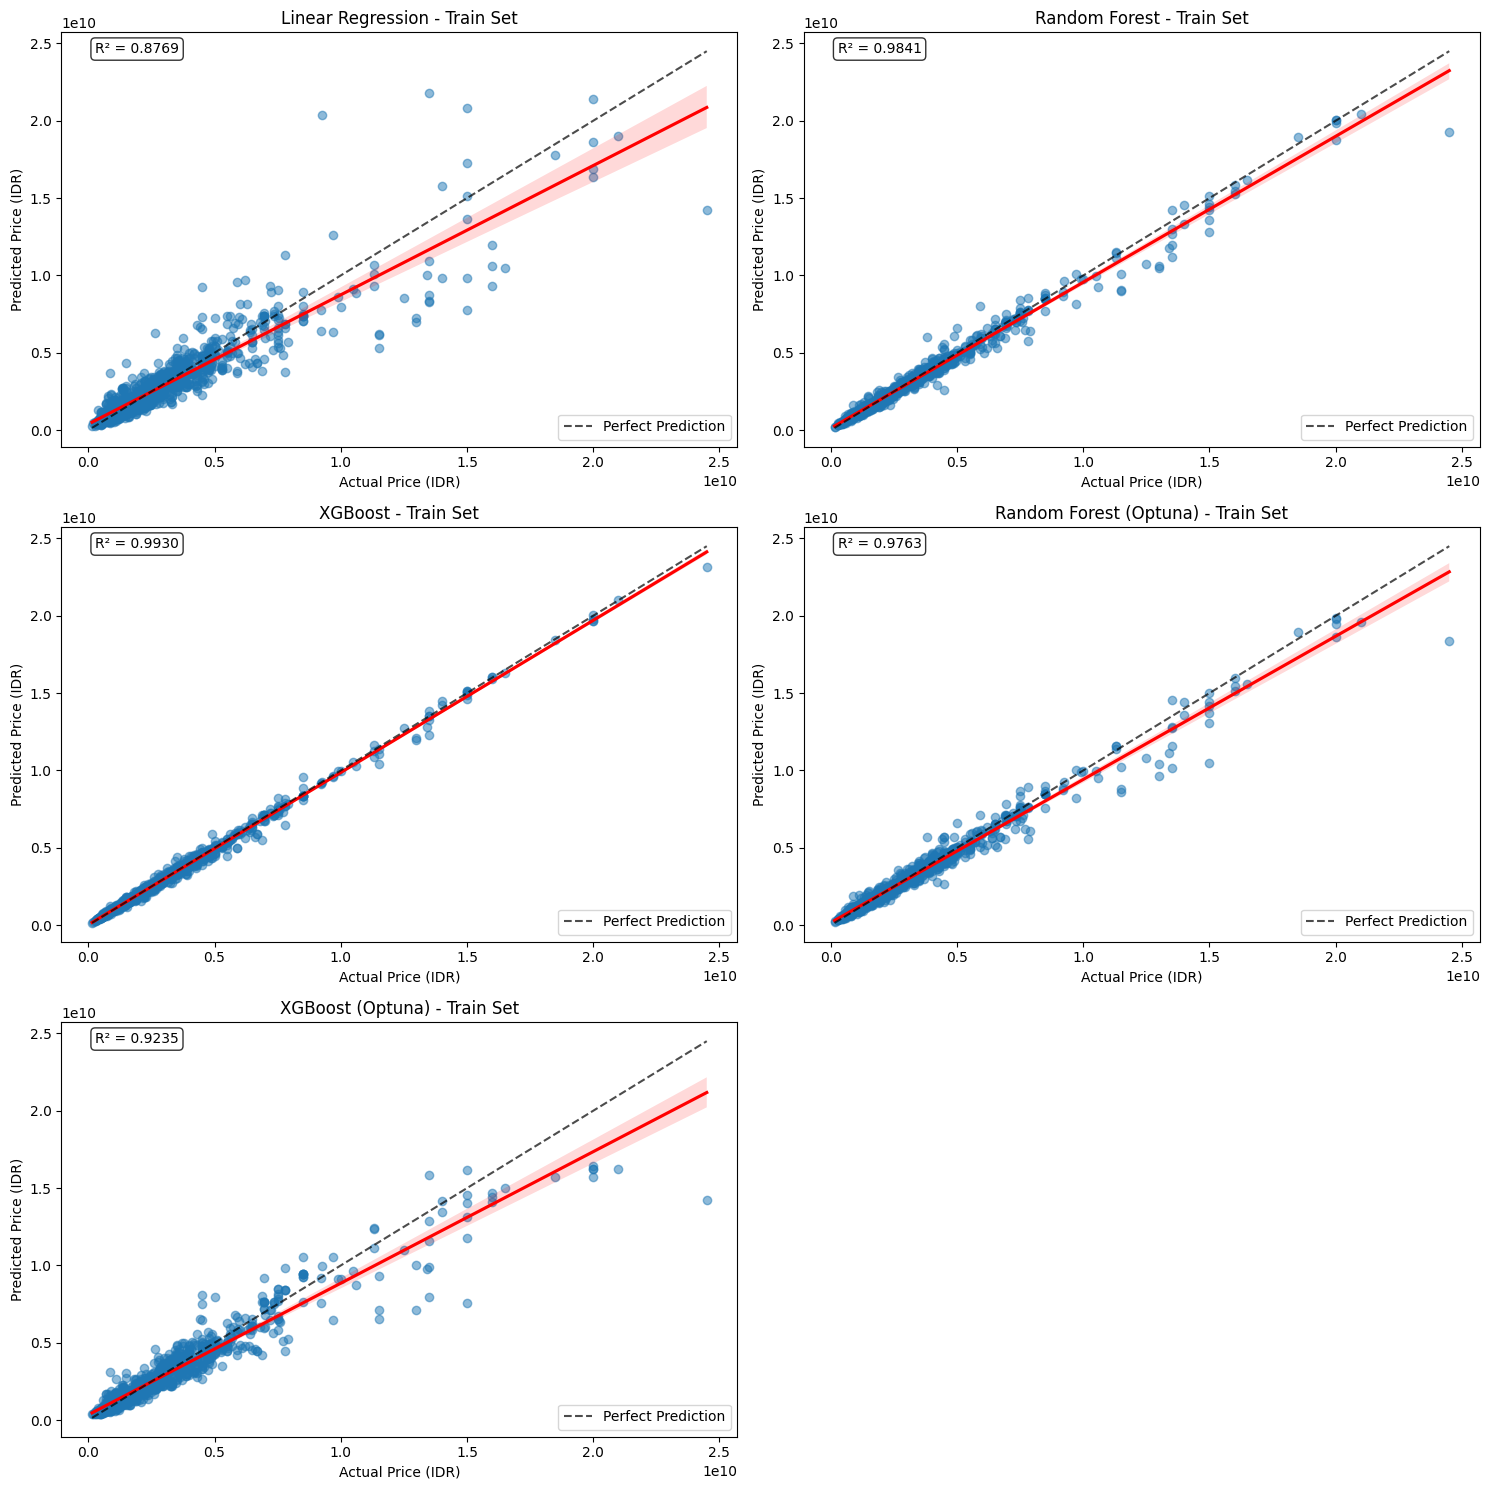

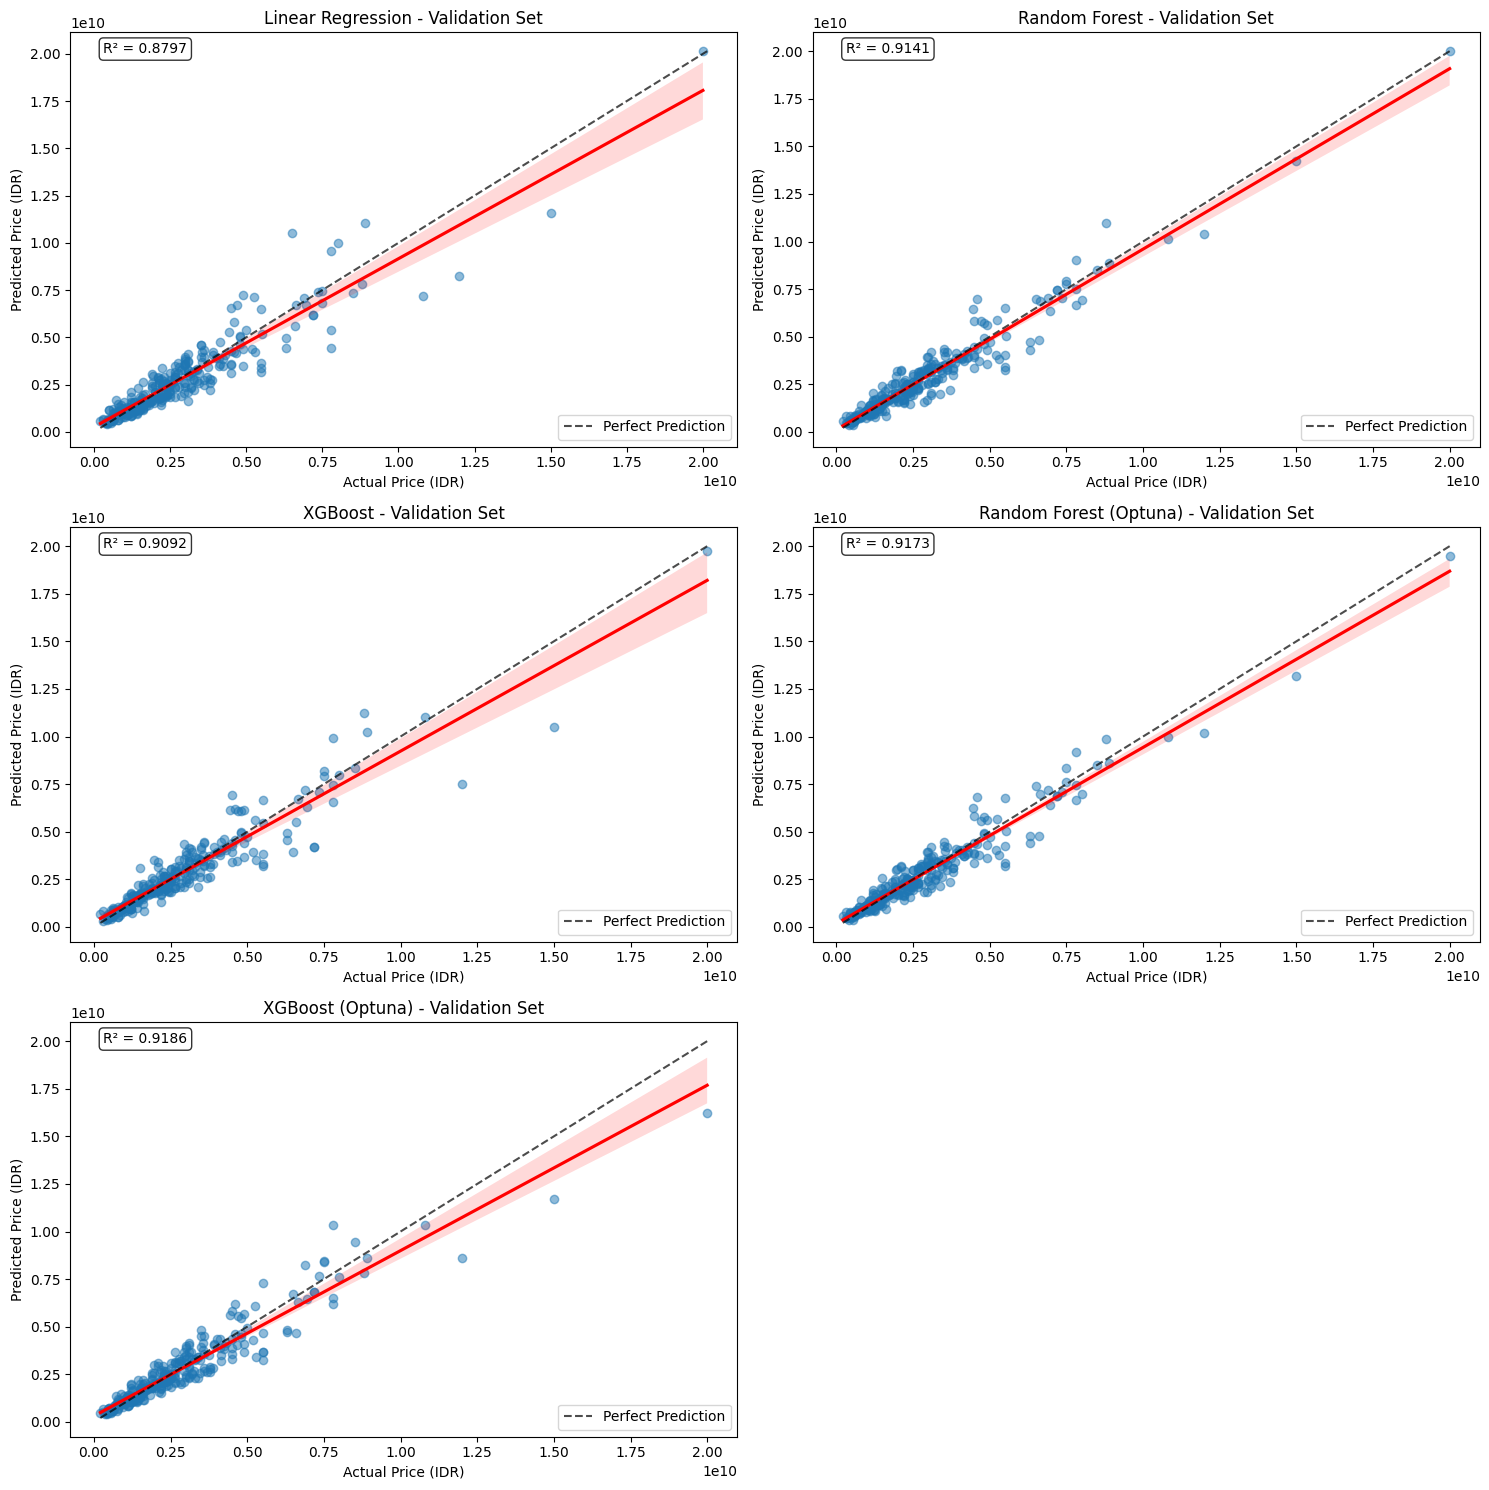

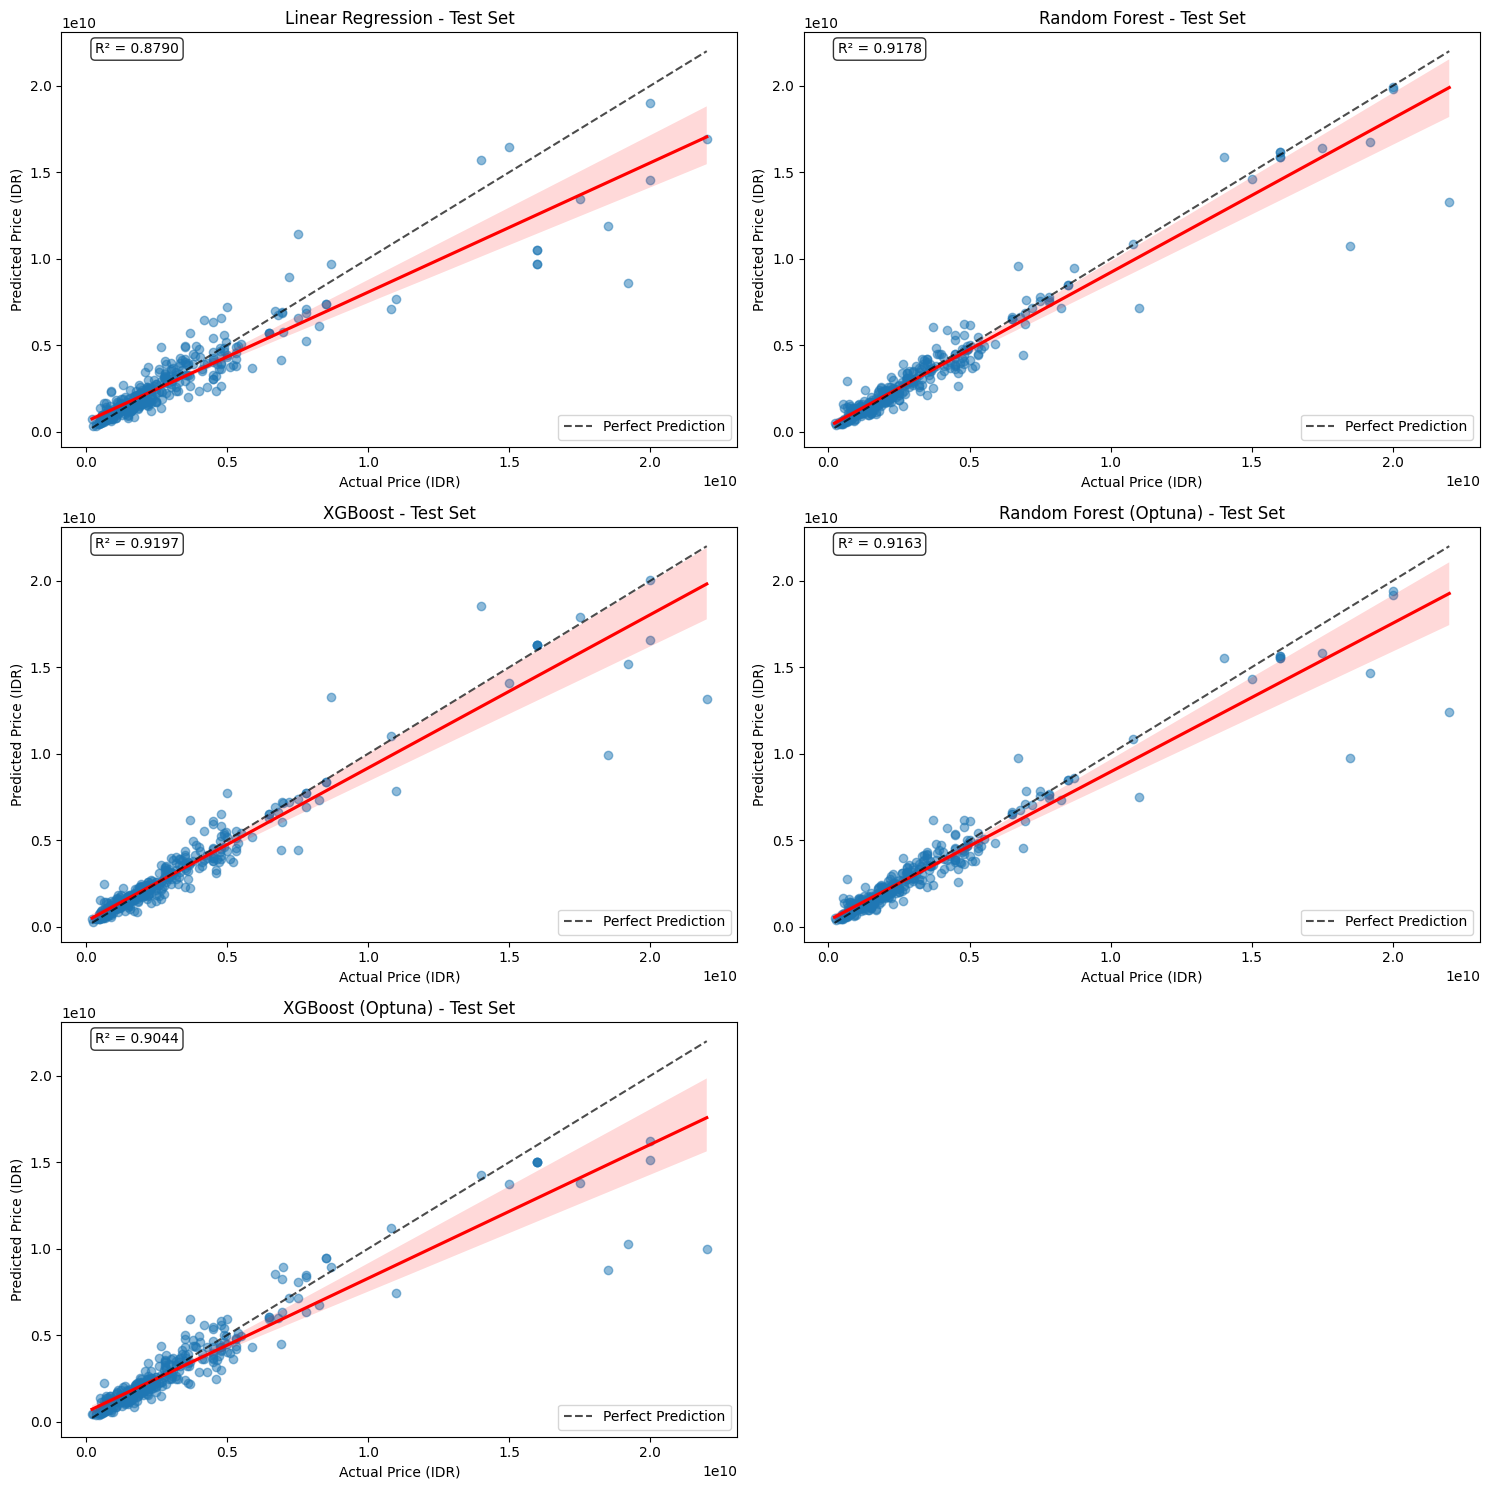

Displaying sample predictions...

📊 PREDICTION SAMPLES - LINEAR REGRESSION

TRAIN SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 8,500,000,000","IDR 7,359,292,602","IDR -1,140,707,398",-13.4%
2,"IDR 4,600,000,000","IDR 3,310,870,195","IDR -1,289,129,805",-28.0%
3,"IDR 3,000,000,000","IDR 2,850,619,014","IDR -149,380,986",-5.0%
4,"IDR 560,000,000","IDR 911,123,105","IDR 351,123,105",62.7%
5,"IDR 1,350,000,000","IDR 1,681,065,415","IDR 331,065,415",24.5%



VALIDATION SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 950,000,000","IDR 965,164,073","IDR 15,164,073",1.6%
2,"IDR 3,500,000,000","IDR 4,589,075,711","IDR 1,089,075,711",31.1%
3,"IDR 1,020,000,000","IDR 808,037,903","IDR -211,962,097",-20.8%
4,"IDR 1,100,000,000","IDR 900,154,392","IDR -199,845,608",-18.2%
5,"IDR 1,900,000,000","IDR 1,615,468,330","IDR -284,531,670",-15.0%



TEST SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 4,600,000,000","IDR 3,237,765,043","IDR -1,362,234,957",-29.6%
2,"IDR 1,500,000,000","IDR 1,883,831,541","IDR 383,831,541",25.6%
3,"IDR 6,950,000,000","IDR 6,880,976,957","IDR -69,023,043",-1.0%
4,"IDR 1,880,000,000","IDR 2,168,684,039","IDR 288,684,039",15.4%
5,"IDR 4,500,000,000","IDR 3,020,075,762","IDR -1,479,924,238",-32.9%



📊 PREDICTION SAMPLES - RANDOM FOREST

TRAIN SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 8,500,000,000","IDR 8,500,000,000",IDR 0,0.0%
2,"IDR 4,600,000,000","IDR 4,470,951,659","IDR -129,048,341",-2.8%
3,"IDR 3,000,000,000","IDR 3,004,450,585","IDR 4,450,585",0.1%
4,"IDR 560,000,000","IDR 624,599,632","IDR 64,599,632",11.5%
5,"IDR 1,350,000,000","IDR 1,427,576,971","IDR 77,576,971",5.7%



VALIDATION SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 950,000,000","IDR 938,778,929","IDR -11,221,071",-1.2%
2,"IDR 3,500,000,000","IDR 4,375,977,064","IDR 875,977,064",25.0%
3,"IDR 1,020,000,000","IDR 874,654,188","IDR -145,345,812",-14.2%
4,"IDR 1,100,000,000","IDR 886,535,598","IDR -213,464,402",-19.4%
5,"IDR 1,900,000,000","IDR 1,790,078,027","IDR -109,921,973",-5.8%



TEST SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 4,600,000,000","IDR 3,379,601,638","IDR -1,220,398,362",-26.5%
2,"IDR 1,500,000,000","IDR 1,079,315,931","IDR -420,684,069",-28.0%
3,"IDR 6,950,000,000","IDR 6,195,238,839","IDR -754,761,161",-10.9%
4,"IDR 1,880,000,000","IDR 2,566,372,691","IDR 686,372,691",36.5%
5,"IDR 4,500,000,000","IDR 3,832,323,181","IDR -667,676,819",-14.8%



📊 PREDICTION SAMPLES - XGBOOST

TRAIN SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 8,500,000,000","IDR 8,358,925,824","IDR -141,074,176",-1.7%
2,"IDR 4,600,000,000","IDR 4,534,218,752","IDR -65,781,248",-1.4%
3,"IDR 3,000,000,000","IDR 3,170,712,064","IDR 170,712,064",5.7%
4,"IDR 560,000,000","IDR 604,733,696","IDR 44,733,696",8.0%
5,"IDR 1,350,000,000","IDR 1,379,486,592","IDR 29,486,592",2.2%



VALIDATION SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 950,000,000","IDR 1,100,966,400","IDR 150,966,400",15.9%
2,"IDR 3,500,000,000","IDR 4,117,364,992","IDR 617,364,992",17.6%
3,"IDR 1,020,000,000","IDR 1,032,382,016","IDR 12,382,016",1.2%
4,"IDR 1,100,000,000","IDR 808,953,088","IDR -291,046,912",-26.5%
5,"IDR 1,900,000,000","IDR 1,949,232,000","IDR 49,232,000",2.6%



TEST SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 4,600,000,000","IDR 3,086,329,344","IDR -1,513,670,656",-32.9%
2,"IDR 1,500,000,000","IDR 1,122,623,232","IDR -377,376,768",-25.2%
3,"IDR 6,950,000,000","IDR 6,077,554,688","IDR -872,445,312",-12.6%
4,"IDR 1,880,000,000","IDR 2,175,716,096","IDR 295,716,096",15.7%
5,"IDR 4,500,000,000","IDR 3,779,286,784","IDR -720,713,216",-16.0%



📊 PREDICTION SAMPLES - RANDOM FOREST (OPTUNA)

TRAIN SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 8,500,000,000","IDR 8,506,539,217","IDR 6,539,217",0.1%
2,"IDR 4,600,000,000","IDR 4,444,713,566","IDR -155,286,434",-3.4%
3,"IDR 3,000,000,000","IDR 3,010,272,826","IDR 10,272,826",0.3%
4,"IDR 560,000,000","IDR 636,094,142","IDR 76,094,142",13.6%
5,"IDR 1,350,000,000","IDR 1,467,548,487","IDR 117,548,487",8.7%



VALIDATION SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 950,000,000","IDR 945,050,748","IDR -4,949,252",-0.5%
2,"IDR 3,500,000,000","IDR 4,448,869,051","IDR 948,869,051",27.1%
3,"IDR 1,020,000,000","IDR 896,746,605","IDR -123,253,395",-12.1%
4,"IDR 1,100,000,000","IDR 856,457,755","IDR -243,542,245",-22.1%
5,"IDR 1,900,000,000","IDR 1,958,610,510","IDR 58,610,510",3.1%



TEST SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 4,600,000,000","IDR 3,334,920,991","IDR -1,265,079,009",-27.5%
2,"IDR 1,500,000,000","IDR 1,164,249,784","IDR -335,750,216",-22.4%
3,"IDR 6,950,000,000","IDR 6,120,249,887","IDR -829,750,113",-11.9%
4,"IDR 1,880,000,000","IDR 2,404,921,207","IDR 524,921,207",27.9%
5,"IDR 4,500,000,000","IDR 3,848,052,729","IDR -651,947,271",-14.5%



📊 PREDICTION SAMPLES - XGBOOST (OPTUNA)

TRAIN SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 8,500,000,000","IDR 9,464,607,744","IDR 964,607,744",11.3%
2,"IDR 4,600,000,000","IDR 3,921,928,960","IDR -678,071,040",-14.7%
3,"IDR 3,000,000,000","IDR 3,012,466,432","IDR 12,466,432",0.4%
4,"IDR 560,000,000","IDR 579,763,648","IDR 19,763,648",3.5%
5,"IDR 1,350,000,000","IDR 1,805,236,096","IDR 455,236,096",33.7%



VALIDATION SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 950,000,000","IDR 952,331,008","IDR 2,331,008",0.2%
2,"IDR 3,500,000,000","IDR 4,834,749,440","IDR 1,334,749,440",38.1%
3,"IDR 1,020,000,000","IDR 963,233,344","IDR -56,766,656",-5.6%
4,"IDR 1,100,000,000","IDR 810,655,168","IDR -289,344,832",-26.3%
5,"IDR 1,900,000,000","IDR 1,833,590,912","IDR -66,409,088",-3.5%



TEST SET:


Sample,Actual,Predicted,Difference,Error %
1,"IDR 4,600,000,000","IDR 3,149,477,632","IDR -1,450,522,368",-31.5%
2,"IDR 1,500,000,000","IDR 1,418,343,936","IDR -81,656,064",-5.4%
3,"IDR 6,950,000,000","IDR 6,350,032,896","IDR -599,967,104",-8.6%
4,"IDR 1,880,000,000","IDR 1,943,678,080","IDR 63,678,080",3.4%
5,"IDR 4,500,000,000","IDR 3,631,517,952","IDR -868,482,048",-19.3%


In [30]:
# === PREDICTION ANALYSIS ===
print("\n🔍 PREDICTION ANALYSIS")
print("=" * 50)

# 1. Plot predictions for all sets
print("Plotting prediction comparisons...")
evaluator.plot_predictions_comparison(all_metrics, all_predictions, set_type='train')
evaluator.plot_predictions_comparison(all_metrics, all_predictions, set_type='validation')
evaluator.plot_predictions_comparison(all_metrics, all_predictions, set_type='test')

# 2. Show sample predictions
print("Displaying sample predictions...")
samples = evaluator.create_prediction_samples(all_metrics, all_predictions, n_samples=5)
evaluator.display_prediction_samples(samples)


📊 MODEL VISUALIZATIONS
Plotting convergence graphs...


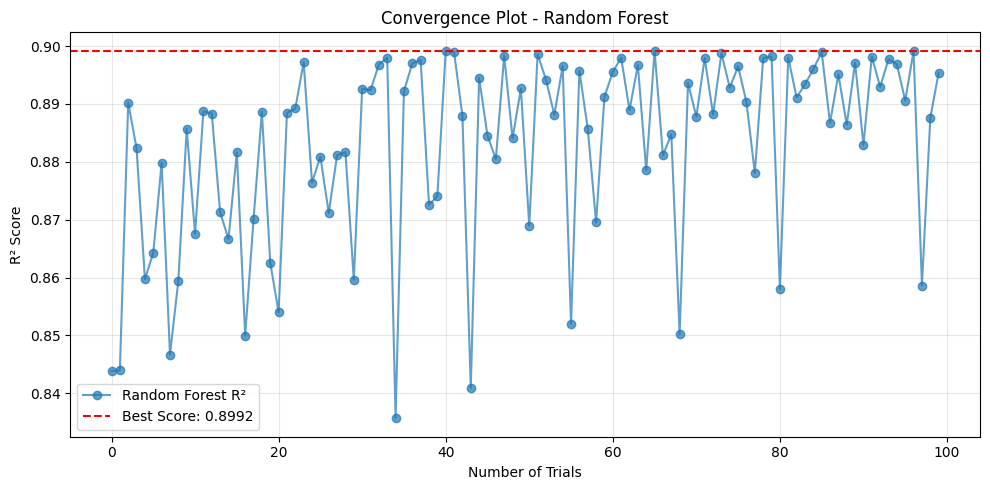

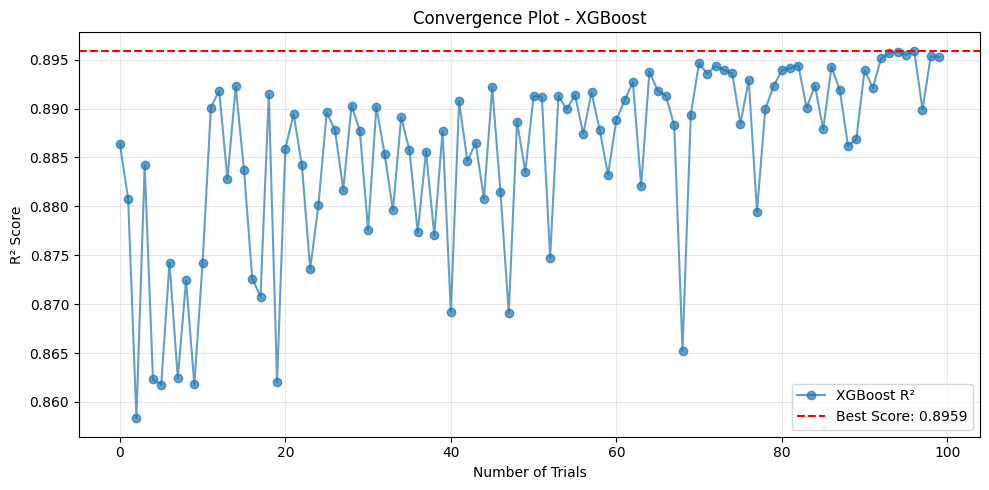

Plotting learning curves...


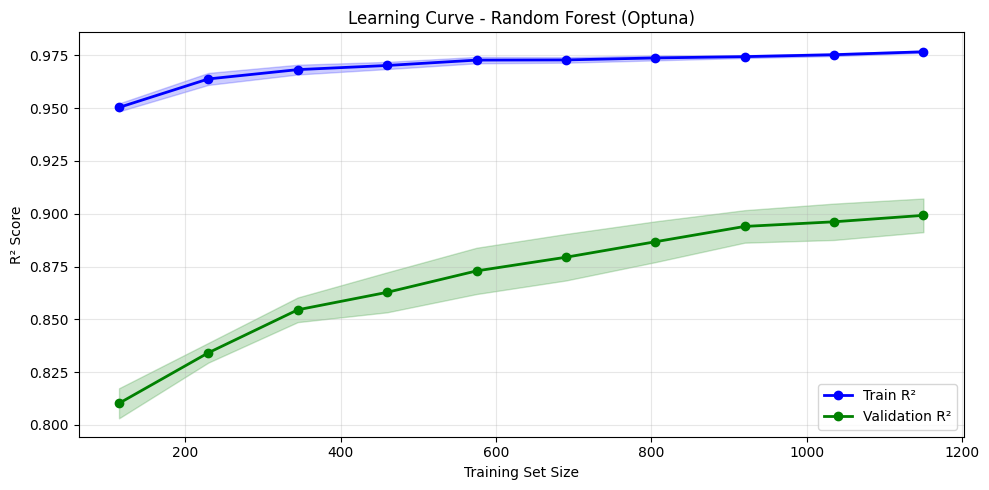

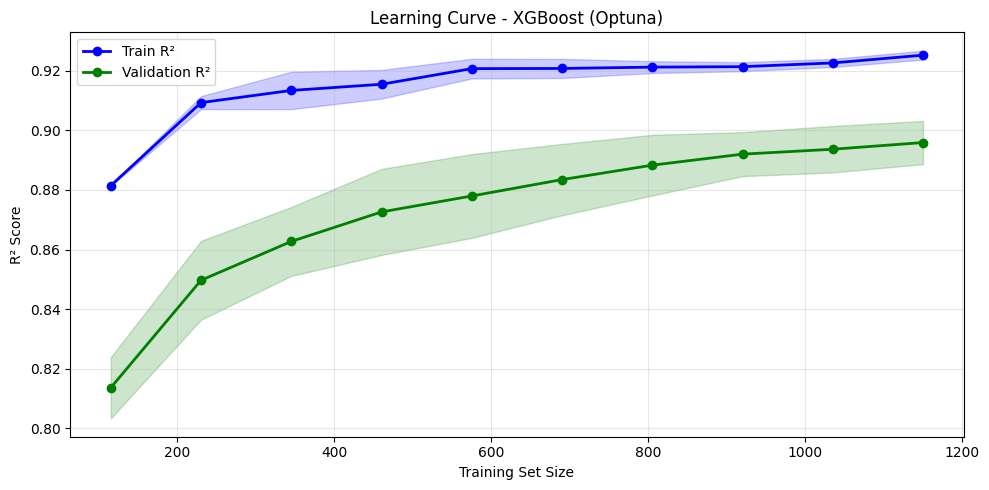

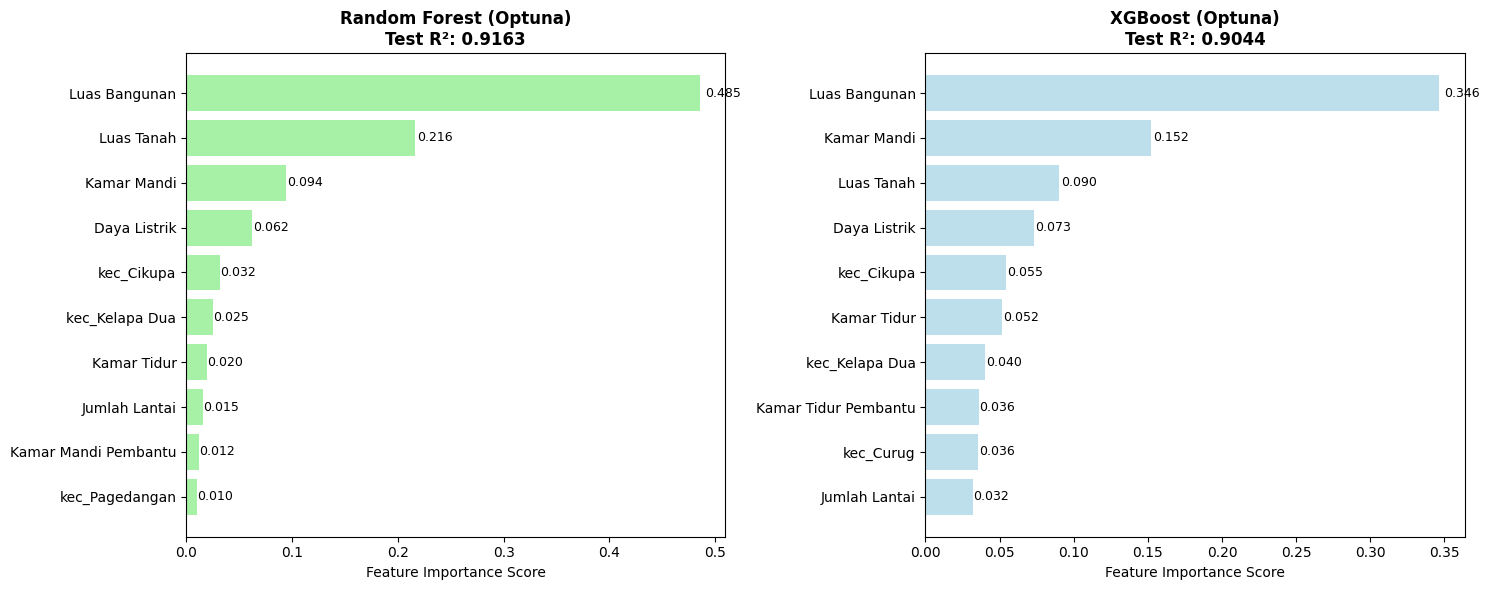


🏆 TOP FEATURES FOR OPTUNA-TUNED MODELS:

Random Forest (Optuna):
  - Luas Bangunan: 0.4853
  - Luas Tanah: 0.2160
  - Kamar Mandi: 0.0940
  - Daya Listrik: 0.0624
  - kec_Cikupa: 0.0321

XGBoost (Optuna):
  - Luas Bangunan: 0.3463
  - Kamar Mandi: 0.1521
  - Luas Tanah: 0.0903
  - Daya Listrik: 0.0730
  - kec_Cikupa: 0.0545


In [31]:
# === VISUALIZATIONS ===
print("\n📊 MODEL VISUALIZATIONS")
print("=" * 50)

# Convergence Plots
print("Plotting convergence graphs...")
evaluator.plot_convergence(rf_study, "Random Forest")
evaluator.plot_convergence(xgb_study, "XGBoost")

# Learning Curves
print("Plotting learning curves...")
best_rf_model = RandomForestRegressor(**rf_best_params, random_state=42, n_jobs=-1)
best_xgb_model = XGBRegressor(**xgb_best_params, random_state=42, n_jobs=-1)

evaluator.plot_learning_curve(best_rf_model, X_train_scaled, y_train, "Random Forest (Optuna)")
evaluator.plot_learning_curve(best_xgb_model, X_train_scaled, y_train, "XGBoost (Optuna)")

# Feature Importance
# Get feature names (from your training data)
feature_names = X_train.columns.tolist()

# Plot feature importance for Optuna-tuned models only
evaluator.plot_tuned_models_feature_importance(
    tuned_models=all_models,        # Your list of all trained models
    tuned_metrics=all_metrics,      # Your list of all metrics
    feature_names=feature_names,    # Feature names from X_train
    figsize=(15, 6)
)

# Optional: Print top features for tuned models
print("\n🏆 TOP FEATURES FOR OPTUNA-TUNED MODELS:")
for i, (model, metrics) in enumerate(zip(all_models, all_metrics)):
    if 'Optuna' in metrics.get('model_name', ''):
        model_name = metrics['model_name']
        importance_values, importance_labels = evaluator._get_feature_importance(model, feature_names)
        
        if importance_values is not None:
            top_indices = np.argsort(importance_values)[-5:][::-1]  # Top 5 features
            top_features = [importance_labels[j] for j in top_indices]
            top_scores = importance_values[top_indices]
            
            print(f"\n{model_name}:")
            for feature, score in zip(top_features, top_scores):
                print(f"  - {feature}: {score:.4f}")

In [32]:
print("\n📈 COMPREHENSIVE MODEL RESULTS")
print("=" * 50)

results_df, styled_results = evaluator.create_results_table(all_metrics)
display(styled_results)


📈 COMPREHENSIVE MODEL RESULTS


According to the overall performance on Train, Validation, and Test set, here are the summary of each models:
1. Multiple Linear Regression <br>
The MLR model shows a solid base performance on all train, validation, and test set.
2. Random Forest <br>
The Random Forest model shows an excellent performance on train set, but unable to generalize well on a new unseen data. This thing can be seen on the differences on validation and test set compared to the train set performance. This clearly shows an overfitting indication of the model.
3. XGBoost <br>
Similar to the Random Forest, the XGBoost model also shows an excellent performance on train set, but unable to replicate the same performance on both validation and test set. This also clearly shows an overfitting indication of the model.
4. Optuna-tuned Random Forest <br>
The optuna-tuned Random Forest model shows a little improvement, where the gap perfromance result on train, validation, test set is reduced by ~2%. However, the optuna-tuned random forest model also indicated that it is experiencing an overfitting issue.
5. Optuna-tuned XGBoost <br>
While the performance of the XGBoost is not the highest among all the model used, it clearly shows the best fit among all the models. The performance gap between train, validation, and test set is not as higher as other models. This clearly the Optuna-tuned XGBoost model can generalize pretty well on a new unseen data.

In [33]:
# # Save model XGBoost Optuna
# with open("./models/xgboost_optuna.pkl", "wb") as f:
#     pickle.dump(xgb_tuned_model, f)

# # Save Ordinal Encoder Daya Listrik
# with open("./models/encoder_data_listrik.pkl", "wb") as f:
#     pickle.dump(daya_listrik_encoder, f)

# # Save Scaler
# with open("./models/scaler.pkl", "wb") as f:
#     pickle.dump(scaler, f)

# print("Semua objek telah disimpan dalam file .pkl!")